# Clasificación de Imágenes Histopatológicas de Osteosarcoma

Comparación de 4 modelos de Deep Learning: VGG16, ResNet50, MobileNetV2, EfficientNetB0

### Obtener librerías necesarias

In [1]:
!pip install tensorflow numpy pandas matplotlib seaborn scikit-learn Pillow opencv-python tqdm statsmodels ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.0 MB/s eta 0:00:00


### Configuración de rutas

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, EfficientNetB0
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import PIL
from PIL import Image
from tqdm.notebook import tqdm
import cv2
import gc

# Para la prueba de McNemar
from statsmodels.stats.contingency_tables import mcnemar

# Asegúrate de tener la GPU activada
print("GPU disponible:", tf.test.is_gpu_available())
print("Dispositivos TensorFlow:", tf.config.list_physical_devices('GPU'))

# Función para montar Google Drive si estamos en Colab
try:
    from google.colab import drive
    IN_COLAB = True
    print("Ejecutando en Google Colab. Montando Google Drive...")
    drive.mount('/content/drive')
    # Cambiar al directorio correspondiente si es necesario
    %cd /content/drive/MyDrive/Datasets/Osteosarcoma/
except:
    IN_COLAB = False
    print("No estamos ejecutando en Google Colab")

# Configurar rutas
# Ajusta estas rutas según donde tengas tus datos
DATA_DIR = '/content/drive/MyDrive/Datasets/Osteosarcoma/images'  # Carpeta con las imágenes
CSV_PATH = '/content/drive/MyDrive/Datasets/Osteosarcoma/ML_Features.csv'  # Ruta al archivo CSV

# Liberar memoria GPU si es necesario
def clear_memory():
    gc.collect()
    tf.keras.backend.clear_session()
    print("Memoria liberada")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU disponible: True
Dispositivos TensorFlow: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Ejecutando en Google Colab. Montando Google Drive...
Mounted at /content/drive
/content/drive/MyDrive/Datasets/Osteosarcoma


### Carga y preprocesamiento de datos

In [3]:
# Cargar el CSV con las etiquetas
df = pd.read_csv(CSV_PATH)

# Mostramos las primeras filas para entender la estructura
print("Primeras filas del dataset:")
df.head()

# Información sobre el dataset
print("\nInformación del dataset:")
df.info()

# Verificar las clases disponibles
print("\nClases disponibles:", df['classification'].unique())
print("Distribución de clases:")
print(df['classification'].value_counts())

# Corregir los nombres de archivo como se solicita
df['image_path'] = df['image.name'].astype(str).str.replace(' - ', '-').str.replace(' ','-') + '.jpg'

# Verificar que el formato de las rutas de las imágenes sea el correcto
print("\nEjemplos de rutas de imágenes:")
print(df['image_path'].head())

# Codificar las labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['classification'])

# Mapeo de las clases
class_mapping = {idx: label for idx, label in enumerate(label_encoder.classes_)}
print("\nMapeo de clases:", class_mapping)

# Verificar si todas las imágenes existen
def check_images_exist(data_dir, df):
    missing_images = []
    for img_path in df['image_path']:
        full_path = os.path.join(data_dir, img_path)
        if not os.path.exists(full_path):
            missing_images.append(img_path)

    if missing_images:
        print(f"¡Advertencia! {len(missing_images)} imágenes no encontradas:")
        print(missing_images[:5], "..." if len(missing_images) > 5 else "")
    else:
        print("Todas las imágenes están disponibles.")

    return missing_images

missing_images = check_images_exist(DATA_DIR, df)

# Filtrar filas con imágenes faltantes
if missing_images:
    df = df[~df['image_path'].isin(missing_images)]
    print(f"Dataset filtrado: {len(df)} imágenes disponibles")

# Dividir en conjuntos de entrenamiento y validación (70% / 30%)
train_df, val_df = train_test_split(
    df,
    test_size=0.3,
    stratify=df['classification'],
    random_state=42
)

print(f"\nConjunto de entrenamiento: {len(train_df)} imágenes")
print(f"Conjunto de validación: {len(val_df)} imágenes")

# Verificar la distribución de clases en los conjuntos de entrenamiento y validación
print("\nDistribución de clases en el conjunto de entrenamiento:")
print(train_df['classification'].value_counts())
print("\nDistribución de clases en el conjunto de validación:")
print(val_df['classification'].value_counts())

Primeras filas del dataset:

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1144 entries, 0 to 1143
Data columns (total 69 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     1144 non-null   int64  
 1   image.name                             1144 non-null   object 
 2   X.x                                    1144 non-null   int64  
 3   Blue.count                             1144 non-null   int64  
 4   red.count                              1144 non-null   int64  
 5   Blue.percentage                        1144 non-null   float64
 6   red.percentage                         1144 non-null   float64
 7   total.clusters                         1144 non-null   int64  
 8   average.clusters.32                    1144 non-null   float64
 9   area                                   1143 non-null   float64
 10  circularity       

### Funciones para cargar y preprocesar imágenes

Cargando imágenes de entrenamiento...


  0%|          | 0/800 [00:00<?, ?it/s]

Cargando imágenes de validación...


  0%|          | 0/344 [00:00<?, ?it/s]

X_train shape: (800, 224, 224, 3)
X_val shape: (344, 224, 224, 3)
Número de clases: 4


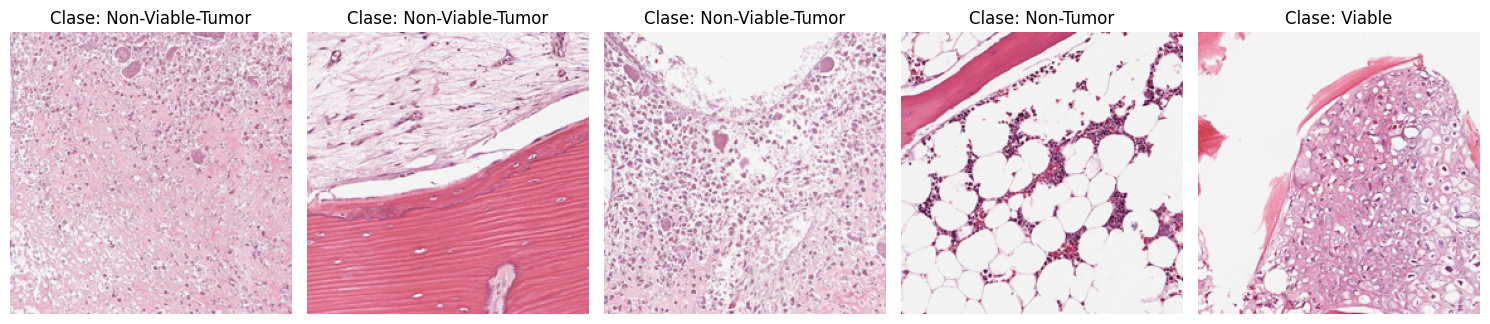

In [4]:
# Función para cargar y redimensionar imágenes
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    try:
        full_path = os.path.join(DATA_DIR, image_path)
        img = Image.open(full_path)
        img = img.resize(target_size)
        img_array = np.array(img)

        # Asegurarse de que la imagen tiene 3 canales (RGB)
        if len(img_array.shape) == 2:
            img_array = np.stack([img_array, img_array, img_array], axis=-1)
        elif img_array.shape[2] == 1:
            img_array = np.concatenate([img_array, img_array, img_array], axis=-1)
        elif img_array.shape[2] == 4:  # RGBA
            img_array = img_array[:, :, :3]

        return img_array
    except Exception as e:
        print(f"Error cargando imagen {image_path}: {e}")
        return None

# Cargar todas las imágenes
print("Cargando imágenes de entrenamiento...")
X_train = []
y_train = []
for idx, row in tqdm(train_df.iterrows(), total=len(train_df)):
    img = load_and_preprocess_image(row['image_path'])
    if img is not None:
        X_train.append(img)
        y_train.append(row['label_encoded'])

print("Cargando imágenes de validación...")
X_val = []
y_val = []
for idx, row in tqdm(val_df.iterrows(), total=len(val_df)):
    img = load_and_preprocess_image(row['image_path'])
    if img is not None:
        X_val.append(img)
        y_val.append(row['label_encoded'])

# Convertir a arrays de numpy
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")

# Crear generators para data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

# Número de clases
num_classes = len(label_encoder.classes_)
print(f"Número de clases: {num_classes}")

# Visualizar algunas imágenes para verificar
def visualize_samples(X, y, class_mapping, n_samples=5):
    plt.figure(figsize=(15, 10))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i+1)
        plt.imshow(X[i].astype('uint8'))
        plt.title(f"Clase: {class_mapping[y[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_samples(X_train, y_train, class_mapping)

### Definición de los modelos

In [5]:
# 1. Modelo VGG16
def create_vgg16_model(input_shape=(224, 224, 3), num_classes=4):
    # Cargar modelo base pre-entrenado
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Congelar las capas convolucionales
    for layer in base_model.layers:
        layer.trainable = False

    # Añadir capas para clasificación
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Crear el modelo
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compilar
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# 2. Modelo ResNet50
def create_resnet50_model(input_shape=(224, 224, 3), num_classes=4):
    # Cargar modelo base pre-entrenado
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Congelar las capas convolucionales
    for layer in base_model.layers:
        layer.trainable = False

    # Añadir capas para clasificación
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Crear el modelo
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compilar
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# 3. Modelo MobileNetV2
def create_mobilenetv2_model(input_shape=(224, 224, 3), num_classes=4):
    # Cargar modelo base pre-entrenado
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Congelar las capas convolucionales
    for layer in base_model.layers:
        layer.trainable = False

    # Añadir capas para clasificación
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Crear el modelo
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compilar
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# 4. Modelo EfficientNetB0
def create_efficientnetb0_model(input_shape=(224, 224, 3), num_classes=4):
    # Cargar modelo base pre-entrenado
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

    # Congelar las capas convolucionales
    for layer in base_model.layers:
        layer.trainable = False

    # Añadir capas para clasificación
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Crear el modelo
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compilar
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

### Función para entrenar los modelos

In [6]:
# Función para entrenar los modelos con verificación de existencia previa
def train_model(model, model_name, X_train, y_train, X_val, y_val,
                preprocessing_func=None, batch_size=32, epochs=30):

    # Verificar si ya existe un modelo entrenado
    model_path = f'{model_name}.h5'
    if os.path.exists(model_path):
        print(f"Modelo pre-entrenado encontrado en {model_path}. Cargando modelo...")
        loaded_model = load_model(model_path)
        # Return an empty history dictionary when loading a model
        return loaded_model, {}

    print(f"No se encontró modelo pre-entrenado. Entrenando {model_name}...")

    # Callbacks para mejorar el entrenamiento
    checkpoint = ModelCheckpoint(
        model_path,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='max'
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=1,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    callbacks = [checkpoint, early_stopping, reduce_lr]

    # Preprocesamiento para los modelos CNN
    if preprocessing_func:
        # Crear generadores con función de preprocesamiento
        train_datagen_with_preproc = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            preprocessing_function=preprocessing_func
        )

        val_datagen_with_preproc = ImageDataGenerator(
            preprocessing_function=preprocessing_func
        )

        train_gen = train_datagen_with_preproc.flow(
            X_train, y_train,
            batch_size=batch_size,
            shuffle=True
        )

        val_gen = val_datagen_with_preproc.flow(
            X_val, y_val,
            batch_size=batch_size,
            shuffle=False
        )
    else:
        # Generadores estándar con normalización simple
        train_datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            rescale=1./255
        )

        val_datagen = ImageDataGenerator(rescale=1./255)

        train_gen = train_datagen.flow(
            X_train, y_train,
            batch_size=batch_size,
            shuffle=True
        )

        val_gen = val_datagen.flow(
            X_val, y_val,
            batch_size=batch_size,
            shuffle=False
        )

    # Entrenar el modelo
    history = model.fit(
        train_gen,
        steps_per_epoch=len(X_train) // batch_size,
        epochs=epochs,
        validation_data=val_gen,
        validation_steps=len(X_val) // batch_size,
        callbacks=callbacks,
        verbose=1
    )

    return model, history

### Entrenamiento de los modelos

In [7]:
# Entrenamos los 4 modelos
models = {}
histories = {}
batch_size = 32
epochs = 100  # Máximo de 100 epochs, para prevenir overfitting, puede terminarse antes

# 1. VGG16
print("\n=== Entrenando VGG16 ===")
clear_memory()
vgg16_model = create_vgg16_model(num_classes=num_classes)
vgg16_model, vgg16_history = train_model(
    vgg16_model, 'vgg16_osteosarcoma',
    X_train, y_train, X_val, y_val,
    preprocessing_func=vgg_preprocess,
    batch_size=batch_size, epochs=epochs
)
models['VGG16'] = vgg16_model
histories['VGG16'] = vgg16_history

# 2. ResNet50
print("\n=== Entrenando ResNet50 ===")
clear_memory()
resnet50_model = create_resnet50_model(num_classes=num_classes)
resnet50_model, resnet50_history = train_model(
    resnet50_model, 'resnet50_osteosarcoma',
    X_train, y_train, X_val, y_val,
    preprocessing_func=resnet_preprocess,
    batch_size=batch_size, epochs=epochs
)
models['ResNet50'] = resnet50_model
histories['ResNet50'] = resnet50_history

# 3. MobileNetV2
print("\n=== Entrenando MobileNetV2 ===")
clear_memory()
mobilenetv2_model = create_mobilenetv2_model(num_classes=num_classes)
mobilenetv2_model, mobilenetv2_history = train_model(
    mobilenetv2_model, 'mobilenetv2_osteosarcoma',
    X_train, y_train, X_val, y_val,
    preprocessing_func=mobilenet_preprocess,
    batch_size=batch_size, epochs=epochs
)
models['MobileNetV2'] = mobilenetv2_model
histories['MobileNetV2'] = mobilenetv2_history

# 4. EfficientNetB0
print("\n=== Entrenando EfficientNetB0 ===")
clear_memory()
efficientnetb0_model = create_efficientnetb0_model(num_classes=num_classes)
efficientnetb0_model, efficientnetb0_history = train_model(
    efficientnetb0_model, 'efficientnetb0_osteosarcoma',
    X_train, y_train, X_val, y_val,
    preprocessing_func=efficientnet_preprocess,
    batch_size=batch_size, epochs=epochs
)
models['EfficientNetB0'] = efficientnetb0_model
histories['EfficientNetB0'] = efficientnetb0_history

# Guardar todos los modelos en formato H5 (si no fueron cargados)
for name, model in models.items():
    model_path = f'{name}_osteosarcoma.h5'
    if not os.path.exists(model_path):
        model.save(model_path)
        print(f"Modelo {name} guardado en {model_path}")
    else:
        print(f"El modelo {name} ya existe en {model_path}")


=== Entrenando VGG16 ===
Memoria liberada
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
No se encontró modelo pre-entrenado. Entrenando vgg16_osteosarcoma...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.3398 - loss: 4.3314
Epoch 1: val_accuracy improved from -inf to 0.57812, saving model to vgg16_osteosarcoma.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 540ms/step - accuracy: 0.3414 - loss: 4.3086 - val_accuracy: 0.5781 - val_loss: 1.3594 - learning_rate: 1.0000e-04
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.5326 - loss: 2.2428
Epoch 2: val_accuracy improved from 0.57812 to 0.75000, saving model to vgg16_osteosarcoma.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5332 - loss: 2.2419 - val_accuracy: 0.7500 - val_loss: 0.9162 - learning_rate: 1.0000e-04
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.5711 - loss: 2.1092
Epoch 3: val_accuracy improved from 0.75000 to 0.80937, saving model to vgg16_osteosarcoma.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 496ms/step - accuracy: 0.5731 - loss: 2.0971 - val_accuracy: 0.8094 - val_loss: 0.7496 - learning_rate: 1.0000e-04
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.6704 - loss: 1.5526
Epoch 4: val_accuracy improved from 0.80937 to 0.83438, saving model to vgg16_osteosarcoma.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 570ms/step - accuracy: 0.6706 - loss: 1.5535 - val_accuracy: 0.8344 - val_loss: 0.6989 - learning_rate: 1.0000e-04
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.7291 - loss: 1.2399
Epoch 5: val_accuracy improved from 0.83438 to 0.84688, saving model to vgg16_osteosarcoma.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 568ms/step - accuracy: 0.7287 - loss: 1.2425 - val_accuracy: 0.8469 - val_loss: 0.6283 - learning_rate: 1.0000e-04
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.7361 - loss: 1.2305
Epoch 6: val_accuracy improved from 0.84688 to 0.85312, saving model to vgg16_osteosarcoma.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 571ms/step - accuracy: 0.7367 - loss: 1.2261 - val_accuracy: 0.8531 - val_loss: 0.6151 - learning_rate: 1.0000e-04
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.7441 - loss: 1.0345
Epoch 7: val_accuracy did not improve from 0.85312
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 503ms/step - accuracy: 0.7441 - loss: 1.0332 - val_accuracy: 0.8531 - val_loss: 0.5905 - learning_rate: 1.0000e-04
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.7632 - loss: 0.9863
Epoch 8: val_accuracy improved from 0.85312 to 0.86563, saving model to vgg16_osteosarcoma.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 550ms/step - accuracy: 0.7628 - loss: 0.9857 - val_accuracy: 0.8656 - val_loss: 0.5645 - learning_rate: 1.0000e-04
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.7751 - loss: 0.8921
Epoch 9: val_accuracy improved from 0.86563 to 0.86875, saving model to vgg16_osteosarcoma.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 836ms/step - accuracy: 0.7753 - loss: 0.8915 - val_accuracy: 0.8687 - val_loss: 0.5511 - learning_rate: 1.0000e-04
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.7574 - loss: 0.9194
Epoch 10: val_accuracy improved from 0.86875 to 0.87500, saving model to vgg16_osteosarcoma.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 502ms/step - accuracy: 0.7575 - loss: 0.9182 - val_accuracy: 0.8750 - val_loss: 0.5224 - learning_rate: 1.0000e-04
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.7797 - loss: 0.8317
Epoch 11: val_accuracy did not improve from 0.87500
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 789ms/step - accuracy: 0.7798 - loss: 0.8313 - val_accuracy: 0.8750 - val_loss: 0.5373 - learning_rate: 1.0000e-04
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.8049 - loss: 0.7667
Epoch 12: val_accuracy improved from 0.87500 to 0.87813, saving model to vgg16_osteosarcoma.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 878ms/step - accuracy: 0.8047 - loss: 0.7661 - val_accuracy: 0.8781 - val_loss: 0.5049 - learning_rate: 1.0000e-04
Epoch 13/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.8203 - loss: 0.6057
Epoch 13: val_accuracy improved from 0.87813 to 0.88125, saving model to vgg16_osteosarcoma.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 531ms/step - accuracy: 0.8200 - loss: 0.6065 - val_accuracy: 0.8813 - val_loss: 0.4939 - learning_rate: 1.0000e-04
Epoch 14/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.8113 - loss: 0.6469
Epoch 14: val_accuracy did not improve from 0.88125
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 518ms/step - accuracy: 0.8112 - loss: 0.6470 - val_accuracy: 0.8656 - val_loss: 0.5410 - learning_rate: 1.0000e-04
Epoch 15/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.8543 - loss: 0.5801
Epoch 15: val_accuracy did not improve from 0.88125
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 500ms/step - accuracy: 0.8536 - loss: 0.5821 - val_accuracy: 0.8813 - val_loss: 0.4959 - learning_rate: 1.0000e-04
Epoch 16/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.8182 - loss: 0.5688
Epoch 16: val_accuracy did not improve from 0.88125
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 834ms/step - accuracy: 0.8179 - loss: 0.5719 - val_accuracy: 0.8813 - val_loss: 0.4774 - learning_rate: 1.0000e

25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 548ms/step - accuracy: 0.8207 - loss: 0.5856 - val_accuracy: 0.8844 - val_loss: 0.4525 - learning_rate: 1.0000e-04
Epoch 21/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.8379 - loss: 0.5621
Epoch 21: val_accuracy did not improve from 0.88437
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 517ms/step - accuracy: 0.8380 - loss: 0.5607 - val_accuracy: 0.8813 - val_loss: 0.4460 - learning_rate: 1.0000e-04
Epoch 22/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.8341 - loss: 0.5402
Epoch 22: val_accuracy did not improve from 0.88437
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 513ms/step - accuracy: 0.8340 - loss: 0.5396 - val_accuracy: 0.8719 - val_loss: 0.4753 - learning_rate: 1.0000e-04
Epoch 23/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.8288 - loss: 0.5102
Epoch 23: val_accuracy did not improve from 0.88437
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 467ms/step - accuracy: 0.8291 - loss: 0.5082 - val_accuracy: 0.8844 - val_loss: 0.4619 - learning_rate: 1.0000e

25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 616ms/step - accuracy: 0.4351 - loss: 1.5836 - val_accuracy: 0.7719 - val_loss: 0.6465 - learning_rate: 1.0000e-04
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.7425 - loss: 0.7203
Epoch 2: val_accuracy improved from 0.77188 to 0.83125, saving model to resnet50_osteosarcoma.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 482ms/step - accuracy: 0.7435 - loss: 0.7172 - val_accuracy: 0.8313 - val_loss: 0.5205 - learning_rate: 1.0000e-04
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.8014 - loss: 0.5806
Epoch 3: val_accuracy improved from 0.83125 to 0.85625, saving model to resnet50_osteosarcoma.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 485ms/step - accuracy: 0.8016 - loss: 0.5801 - val_accuracy: 0.8562 - val_loss: 0.4739 - learning_rate: 1.0000e-04
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.7993 - loss: 0.5622
Epoch 4: val_accuracy improved from 0.85625 to 0.87813, saving model to resnet50_osteosarcoma.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8000 - loss: 0.5609 - val_accuracy: 0.8781 - val_loss: 0.4330 - learning_rate: 1.0000e-04
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.8639 - loss: 0.4072
Epoch 5: val_accuracy did not improve from 0.87813
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 517ms/step - accuracy: 0.8634 - loss: 0.4083 - val_accuracy: 0.8750 - val_loss: 0.4165 - learning_rate: 1.0000e-04
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.8743 - loss: 0.3919
Epoch 6: val_accuracy did not improve from 0.87813
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 454ms/step - accuracy: 0.8741 - loss: 0.3920 - val_accuracy: 0.8719 - val_loss: 0.3898 - learning_rate: 1.0000e-04
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8713 - loss: 0.3941
Epoch 7: val_accuracy improved from 0.87813 to 0.88750, saving model to resnet50_osteosarcoma.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 495ms/step - accuracy: 0.8708 - loss: 0.3948 - val_accuracy: 0.8875 - val_loss: 0.3578 - learning_rate: 1.0000e-04
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.8500 - loss: 0.4035
Epoch 8: val_accuracy did not improve from 0.88750
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 473ms/step - accuracy: 0.8506 - loss: 0.4030 - val_accuracy: 0.8719 - val_loss: 0.3904 - learning_rate: 1.0000e-04
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.8663 - loss: 0.3550
Epoch 9: val_accuracy did not improve from 0.88750
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 477ms/step - accuracy: 0.8662 - loss: 0.3550 - val_accuracy: 0.8813 - val_loss: 0.3837 - learning_rate: 1.0000e-04
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.8510 - loss: 0.4203
Epoch 10: val_accuracy did not improve from 0.88750
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 408ms/step - accuracy: 0.8512 - loss: 0.4194 - val_accuracy: 0.8844 - val_loss: 0.3738 - learning_rate: 1.0000e-04


25/25 ━━━━━━━━━━━━━━━━━━━━ 34s 536ms/step - accuracy: 0.8775 - loss: 0.3169 - val_accuracy: 0.8938 - val_loss: 0.3447 - learning_rate: 1.0000e-04
Epoch 14/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.8704 - loss: 0.3078
Epoch 14: val_accuracy improved from 0.89375 to 0.89688, saving model to resnet50_osteosarcoma.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 496ms/step - accuracy: 0.8708 - loss: 0.3082 - val_accuracy: 0.8969 - val_loss: 0.3228 - learning_rate: 1.0000e-04
Epoch 15/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.8818 - loss: 0.3230
Epoch 15: val_accuracy did not improve from 0.89688
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 802ms/step - accuracy: 0.8818 - loss: 0.3235 - val_accuracy: 0.8906 - val_loss: 0.3248 - learning_rate: 1.0000e-04
Epoch 16/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.8839 - loss: 0.3047
Epoch 16: val_accuracy did not improve from 0.89688
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 418ms/step - accuracy: 0.8837 - loss: 0.3049 - val_accuracy: 0.8938 - val_loss: 0.3193 - learning_rate: 1.0000e-04
Epoch 17/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.8951 - loss: 0.3194
Epoch 17: val_accuracy did not improve from 0.89688
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 449ms/step - accuracy: 0.8949 - loss: 0.3190 - val_accuracy: 0.8906 - val_loss: 0.3161 - learning_rate: 1.0000e

25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 542ms/step - accuracy: 0.3384 - loss: 1.8130 - val_accuracy: 0.6531 - val_loss: 0.9049 - learning_rate: 1.0000e-04
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.6542 - loss: 0.9413
Epoch 2: val_accuracy improved from 0.65312 to 0.74375, saving model to mobilenetv2_osteosarcoma.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 436ms/step - accuracy: 0.6544 - loss: 0.9402 - val_accuracy: 0.7437 - val_loss: 0.7023 - learning_rate: 1.0000e-04
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.7393 - loss: 0.7379
Epoch 3: val_accuracy did not improve from 0.74375
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 413ms/step - accuracy: 0.7390 - loss: 0.7387 - val_accuracy: 0.7250 - val_loss: 0.6831 - learning_rate: 1.0000e-04
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.7147 - loss: 0.7958
Epoch 4: val_accuracy improved from 0.74375 to 0.78750, saving model to mobilenetv2_osteosarcoma.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 461ms/step - accuracy: 0.7166 - loss: 0.7929 - val_accuracy: 0.7875 - val_loss: 0.5936 - learning_rate: 1.0000e-04
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.7687 - loss: 0.6564
Epoch 5: val_accuracy did not improve from 0.78750
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 362ms/step - accuracy: 0.7690 - loss: 0.6567 - val_accuracy: 0.7812 - val_loss: 0.5782 - learning_rate: 1.0000e-04
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.7803 - loss: 0.6591
Epoch 6: val_accuracy did not improve from 0.78750
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 412ms/step - accuracy: 0.7809 - loss: 0.6567 - val_accuracy: 0.7781 - val_loss: 0.5819 - learning_rate: 1.0000e-04
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.8073 - loss: 0.5713
Epoch 7: val_accuracy improved from 0.78750 to 0.81250, saving model to mobilenetv2_osteosarcoma.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 427ms/step - accuracy: 0.8078 - loss: 0.5702 - val_accuracy: 0.8125 - val_loss: 0.5305 - learning_rate: 1.0000e-04
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.8272 - loss: 0.5339
Epoch 8: val_accuracy improved from 0.81250 to 0.82187, saving model to mobilenetv2_osteosarcoma.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 426ms/step - accuracy: 0.8267 - loss: 0.5335 - val_accuracy: 0.8219 - val_loss: 0.5018 - learning_rate: 1.0000e-04
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.8370 - loss: 0.5154
Epoch 9: val_accuracy improved from 0.82187 to 0.84688, saving model to mobilenetv2_osteosarcoma.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 454ms/step - accuracy: 0.8370 - loss: 0.5149 - val_accuracy: 0.8469 - val_loss: 0.5024 - learning_rate: 1.0000e-04
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.8221 - loss: 0.5420
Epoch 10: val_accuracy improved from 0.84688 to 0.85938, saving model to mobilenetv2_osteosarcoma.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 400ms/step - accuracy: 0.8224 - loss: 0.5404 - val_accuracy: 0.8594 - val_loss: 0.4635 - learning_rate: 1.0000e-04
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.8686 - loss: 0.4114
Epoch 11: val_accuracy did not improve from 0.85938
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 339ms/step - accuracy: 0.8674 - loss: 0.4136 - val_accuracy: 0.8594 - val_loss: 0.4650 - learning_rate: 1.0000e-04
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.8591 - loss: 0.4340
Epoch 12: val_accuracy did not improve from 0.85938
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 414ms/step - accuracy: 0.8595 - loss: 0.4331 - val_accuracy: 0.8594 - val_loss: 0.4508 - learning_rate: 1.0000e-04
Epoch 13/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8559 - loss: 0.4056
Epoch 13: val_accuracy improved from 0.85938 to 0.86563, saving model to mobilenetv2_osteosarcoma.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 454ms/step - accuracy: 0.8559 - loss: 0.4068 - val_accuracy: 0.8656 - val_loss: 0.4363 - learning_rate: 1.0000e-04
Epoch 14/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.8610 - loss: 0.4172
Epoch 14: val_accuracy improved from 0.86563 to 0.87187, saving model to mobilenetv2_osteosarcoma.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 456ms/step - accuracy: 0.8610 - loss: 0.4171 - val_accuracy: 0.8719 - val_loss: 0.4317 - learning_rate: 1.0000e-04
Epoch 15/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.8511 - loss: 0.4699
Epoch 15: val_accuracy did not improve from 0.87187
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 412ms/step - accuracy: 0.8514 - loss: 0.4686 - val_accuracy: 0.8656 - val_loss: 0.4512 - learning_rate: 1.0000e-04
Epoch 16/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.8498 - loss: 0.4389
Epoch 16: val_accuracy did not improve from 0.87187
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 417ms/step - accuracy: 0.8502 - loss: 0.4375 - val_accuracy: 0.8719 - val_loss: 0.4222 - learning_rate: 1.0000e-04
Epoch 17/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.8710 - loss: 0.3596
Epoch 17: val_accuracy did not improve from 0.87187
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 344ms/step - accuracy: 0.8705 - loss: 0.3608 - val_accuracy: 0.8656 - val_loss: 0.4258 - learning_rate: 1.0000e-

25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 450ms/step - accuracy: 0.8622 - loss: 0.3765 - val_accuracy: 0.8781 - val_loss: 0.4211 - learning_rate: 1.0000e-04
Epoch 20/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.8554 - loss: 0.3863
Epoch 20: val_accuracy improved from 0.87813 to 0.88125, saving model to mobilenetv2_osteosarcoma.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 449ms/step - accuracy: 0.8559 - loss: 0.3858 - val_accuracy: 0.8813 - val_loss: 0.4071 - learning_rate: 1.0000e-04
Epoch 21/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.8599 - loss: 0.3736
Epoch 21: val_accuracy did not improve from 0.88125
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 399ms/step - accuracy: 0.8598 - loss: 0.3737 - val_accuracy: 0.8813 - val_loss: 0.3917 - learning_rate: 1.0000e-04
Epoch 22/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.8895 - loss: 0.3167
Epoch 22: val_accuracy improved from 0.88125 to 0.88750, saving model to mobilenetv2_osteosarcoma.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 447ms/step - accuracy: 0.8887 - loss: 0.3184 - val_accuracy: 0.8875 - val_loss: 0.4016 - learning_rate: 1.0000e-04
Epoch 23/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.8477 - loss: 0.3919
Epoch 23: val_accuracy did not improve from 0.88750
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 385ms/step - accuracy: 0.8480 - loss: 0.3917 - val_accuracy: 0.8813 - val_loss: 0.3977 - learning_rate: 1.0000e-04
Epoch 24/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.8947 - loss: 0.3160
Epoch 24: val_accuracy did not improve from 0.88750
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 351ms/step - accuracy: 0.8942 - loss: 0.3173 - val_accuracy: 0.8813 - val_loss: 0.3949 - learning_rate: 1.0000e-04
Epoch 25/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.8772 - loss: 0.3494
Epoch 25: val_accuracy did not improve from 0.88750
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 414ms/step - accuracy: 0.8771 - loss: 0.3494 - val_accuracy: 0.8844 - val_loss: 0.3807 - learning_rate: 1.0000e-

25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 392ms/step - accuracy: 0.8901 - loss: 0.2951 - val_accuracy: 0.8906 - val_loss: 0.3752 - learning_rate: 1.0000e-04
Epoch 32/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.8764 - loss: 0.3259
Epoch 32: val_accuracy did not improve from 0.89062
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 409ms/step - accuracy: 0.8765 - loss: 0.3260 - val_accuracy: 0.8781 - val_loss: 0.3806 - learning_rate: 1.0000e-04
Epoch 33/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.8715 - loss: 0.3433
Epoch 33: val_accuracy did not improve from 0.89062
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 414ms/step - accuracy: 0.8719 - loss: 0.3417 - val_accuracy: 0.8781 - val_loss: 0.3638 - learning_rate: 1.0000e-04
Epoch 34/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.8790 - loss: 0.3105
Epoch 34: val_accuracy did not improve from 0.89062
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 362ms/step - accuracy: 0.8793 - loss: 0.3103 - val_accuracy: 0.8844 - val_loss: 0.3738 - learning_rate: 1.0000e-

25/25 ━━━━━━━━━━━━━━━━━━━━ 38s 660ms/step - accuracy: 0.4671 - loss: 1.2009 - val_accuracy: 0.6938 - val_loss: 0.9028 - learning_rate: 1.0000e-04
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.6914 - loss: 0.8907
Epoch 2: val_accuracy improved from 0.69375 to 0.72812, saving model to efficientnetb0_osteosarcoma.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 727ms/step - accuracy: 0.6920 - loss: 0.8888 - val_accuracy: 0.7281 - val_loss: 0.7750 - learning_rate: 1.0000e-04
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.7487 - loss: 0.7221
Epoch 3: val_accuracy improved from 0.72812 to 0.77188, saving model to efficientnetb0_osteosarcoma.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 383ms/step - accuracy: 0.7488 - loss: 0.7220 - val_accuracy: 0.7719 - val_loss: 0.6907 - learning_rate: 1.0000e-04
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.7883 - loss: 0.6624
Epoch 4: val_accuracy improved from 0.77188 to 0.78438, saving model to efficientnetb0_osteosarcoma.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 424ms/step - accuracy: 0.7877 - loss: 0.6625 - val_accuracy: 0.7844 - val_loss: 0.6441 - learning_rate: 1.0000e-04
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.8032 - loss: 0.6102
Epoch 5: val_accuracy improved from 0.78438 to 0.80313, saving model to efficientnetb0_osteosarcoma.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 862ms/step - accuracy: 0.8029 - loss: 0.6097 - val_accuracy: 0.8031 - val_loss: 0.5836 - learning_rate: 1.0000e-04
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.7969 - loss: 0.5838
Epoch 6: val_accuracy improved from 0.80313 to 0.81563, saving model to efficientnetb0_osteosarcoma.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 456ms/step - accuracy: 0.7973 - loss: 0.5831 - val_accuracy: 0.8156 - val_loss: 0.5558 - learning_rate: 1.0000e-04
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.7781 - loss: 0.6051
Epoch 7: val_accuracy did not improve from 0.81563
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7794 - loss: 0.6032 - val_accuracy: 0.8156 - val_loss: 0.5437 - learning_rate: 1.0000e-04
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.7969 - loss: 0.5697
Epoch 8: val_accuracy improved from 0.81563 to 0.83125, saving model to efficientnetb0_osteosarcoma.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 456ms/step - accuracy: 0.7979 - loss: 0.5675 - val_accuracy: 0.8313 - val_loss: 0.5108 - learning_rate: 1.0000e-04
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.7972 - loss: 0.5359
Epoch 9: val_accuracy did not improve from 0.83125
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 345ms/step - accuracy: 0.7976 - loss: 0.5352 - val_accuracy: 0.8313 - val_loss: 0.5031 - learning_rate: 1.0000e-04
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.8467 - loss: 0.4830
Epoch 10: val_accuracy improved from 0.83125 to 0.83438, saving model to efficientnetb0_osteosarcoma.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 887ms/step - accuracy: 0.8463 - loss: 0.4828 - val_accuracy: 0.8344 - val_loss: 0.4910 - learning_rate: 1.0000e-04
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.8365 - loss: 0.4661
Epoch 11: val_accuracy improved from 0.83438 to 0.85000, saving model to efficientnetb0_osteosarcoma.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 891ms/step - accuracy: 0.8367 - loss: 0.4659 - val_accuracy: 0.8500 - val_loss: 0.4825 - learning_rate: 1.0000e-04
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.8298 - loss: 0.4692
Epoch 12: val_accuracy did not improve from 0.85000
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 838ms/step - accuracy: 0.8300 - loss: 0.4689 - val_accuracy: 0.8500 - val_loss: 0.4753 - learning_rate: 1.0000e-04
Epoch 13/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.8516 - loss: 0.4376
Epoch 13: val_accuracy improved from 0.85000 to 0.85938, saving model to efficientnetb0_osteosarcoma.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 402ms/step - accuracy: 0.8515 - loss: 0.4374 - val_accuracy: 0.8594 - val_loss: 0.4630 - learning_rate: 1.0000e-04
Epoch 14/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.8580 - loss: 0.4369
Epoch 14: val_accuracy did not improve from 0.85938
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 766ms/step - accuracy: 0.8575 - loss: 0.4374 - val_accuracy: 0.8562 - val_loss: 0.4510 - learning_rate: 1.0000e-04
Epoch 15/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.8659 - loss: 0.4048
Epoch 15: val_accuracy did not improve from 0.85938
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 774ms/step - accuracy: 0.8656 - loss: 0.4056 - val_accuracy: 0.8562 - val_loss: 0.4510 - learning_rate: 1.0000e-04
Epoch 16/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.8608 - loss: 0.4040
Epoch 16: val_accuracy did not improve from 0.85938
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 348ms/step - accuracy: 0.8609 - loss: 0.4040 - val_accuracy: 0.8562 - val_loss: 0.4398 - learning_rate: 1.0000e-

25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 394ms/step - accuracy: 0.8827 - loss: 0.3602 - val_accuracy: 0.8656 - val_loss: 0.3976 - learning_rate: 1.0000e-04
Epoch 28/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.9042 - loss: 0.3084
Epoch 28: val_accuracy did not improve from 0.86563
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 404ms/step - accuracy: 0.9035 - loss: 0.3096 - val_accuracy: 0.8625 - val_loss: 0.3945 - learning_rate: 1.0000e-04
Epoch 29/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.8588 - loss: 0.3773
Epoch 29: val_accuracy improved from 0.86563 to 0.86875, saving model to efficientnetb0_osteosarcoma.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 473ms/step - accuracy: 0.8591 - loss: 0.3768 - val_accuracy: 0.8687 - val_loss: 0.3878 - learning_rate: 1.0000e-04
Epoch 30/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.8879 - loss: 0.3324
Epoch 30: val_accuracy did not improve from 0.86875
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 410ms/step - accuracy: 0.8876 - loss: 0.3331 - val_accuracy: 0.8687 - val_loss: 0.3838 - learning_rate: 1.0000e-04
Epoch 31/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.8850 - loss: 0.3667
Epoch 31: val_accuracy did not improve from 0.86875
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 342ms/step - accuracy: 0.8852 - loss: 0.3657 - val_accuracy: 0.8687 - val_loss: 0.3851 - learning_rate: 1.0000e-04
Epoch 32/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9091 - loss: 0.2934
Epoch 32: val_accuracy did not improve from 0.86875
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 388ms/step - accuracy: 0.9083 - loss: 0.2949 - val_accuracy: 0.8625 - val_loss: 0.3865 - learning_rate: 1.0000e-

25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 394ms/step - accuracy: 0.8814 - loss: 0.3224 - val_accuracy: 0.8719 - val_loss: 0.3821 - learning_rate: 1.0000e-04
Epoch 35/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.8714 - loss: 0.3218
Epoch 35: val_accuracy did not improve from 0.87187
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 345ms/step - accuracy: 0.8714 - loss: 0.3218 - val_accuracy: 0.8687 - val_loss: 0.3717 - learning_rate: 1.0000e-04
Epoch 36/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.8849 - loss: 0.3315
Epoch 36: val_accuracy improved from 0.87187 to 0.87813, saving model to efficientnetb0_osteosarcoma.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 455ms/step - accuracy: 0.8853 - loss: 0.3308 - val_accuracy: 0.8781 - val_loss: 0.3658 - learning_rate: 1.0000e-04
Epoch 37/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9012 - loss: 0.3048
Epoch 37: val_accuracy did not improve from 0.87813
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 402ms/step - accuracy: 0.9010 - loss: 0.3050 - val_accuracy: 0.8687 - val_loss: 0.3658 - learning_rate: 1.0000e-04
Epoch 38/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.8784 - loss: 0.3427
Epoch 38: val_accuracy did not improve from 0.87813
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 406ms/step - accuracy: 0.8784 - loss: 0.3421 - val_accuracy: 0.8781 - val_loss: 0.3576 - learning_rate: 1.0000e-04
Epoch 39/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.8869 - loss: 0.3258
Epoch 39: val_accuracy did not improve from 0.87813
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 337ms/step - accuracy: 0.8870 - loss: 0.3258 - val_accuracy: 0.8781 - val_loss: 0.3621 - learning_rate: 1.0000e-

25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 468ms/step - accuracy: 0.9043 - loss: 0.2787 - val_accuracy: 0.8813 - val_loss: 0.3433 - learning_rate: 1.0000e-04
Epoch 52/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.8845 - loss: 0.2858
Epoch 52: val_accuracy did not improve from 0.88125
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 404ms/step - accuracy: 0.8843 - loss: 0.2863 - val_accuracy: 0.8781 - val_loss: 0.3411 - learning_rate: 1.0000e-04
Epoch 53/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.9208 - loss: 0.2651
Epoch 53: val_accuracy improved from 0.88125 to 0.88437, saving model to efficientnetb0_osteosarcoma.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 451ms/step - accuracy: 0.9199 - loss: 0.2656 - val_accuracy: 0.8844 - val_loss: 0.3399 - learning_rate: 1.0000e-04
Epoch 54/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.9052 - loss: 0.2750
Epoch 54: val_accuracy did not improve from 0.88437
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 339ms/step - accuracy: 0.9052 - loss: 0.2749 - val_accuracy: 0.8813 - val_loss: 0.3448 - learning_rate: 1.0000e-04
Epoch 55/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.9151 - loss: 0.2463
Epoch 55: val_accuracy did not improve from 0.88437
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 753ms/step - accuracy: 0.9149 - loss: 0.2468 - val_accuracy: 0.8813 - val_loss: 0.3412 - learning_rate: 1.0000e-04
Epoch 56/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9101 - loss: 0.2452
Epoch 56: val_accuracy did not improve from 0.88437
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 406ms/step - accuracy: 0.9096 - loss: 0.2461 - val_accuracy: 0.8813 - val_loss: 0.3441 - learning_rate: 1.0000e-

Modelo VGG16 guardado en VGG16_osteosarcoma.h5


Modelo ResNet50 guardado en ResNet50_osteosarcoma.h5


Modelo MobileNetV2 guardado en MobileNetV2_osteosarcoma.h5
Modelo EfficientNetB0 guardado en EfficientNetB0_osteosarcoma.h5


### Evaluación de los modelos


Evaluando VGG16...
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step

VGG16 - Accuracy: 0.8779
VGG16 - F1-Score (Macro): 0.6925
VGG16 - F1-Score (Weighted): 0.8639
VGG16 - F1-Score (Micro): 0.8779
VGG16 - F1-Score por clase:
  Non-Tumor: 0.9408
  Non-Viable-Tumor: 0.8555
  Viable: 0.8686
  viable: non-viable: 0.1053

VGG16 - Classification Report:
                    precision    recall  f1-score   support

         Non-Tumor       0.94      0.94      0.94       161
  Non-Viable-Tumor       0.79      0.94      0.86        79
            Viable       0.87      0.86      0.87        88
viable: non-viable       0.33      0.06      0.11        16

          accuracy                           0.88       344
         macro avg       0.73      0.70      0.69       344
      weighted avg       0.86      0.88      0.86       344



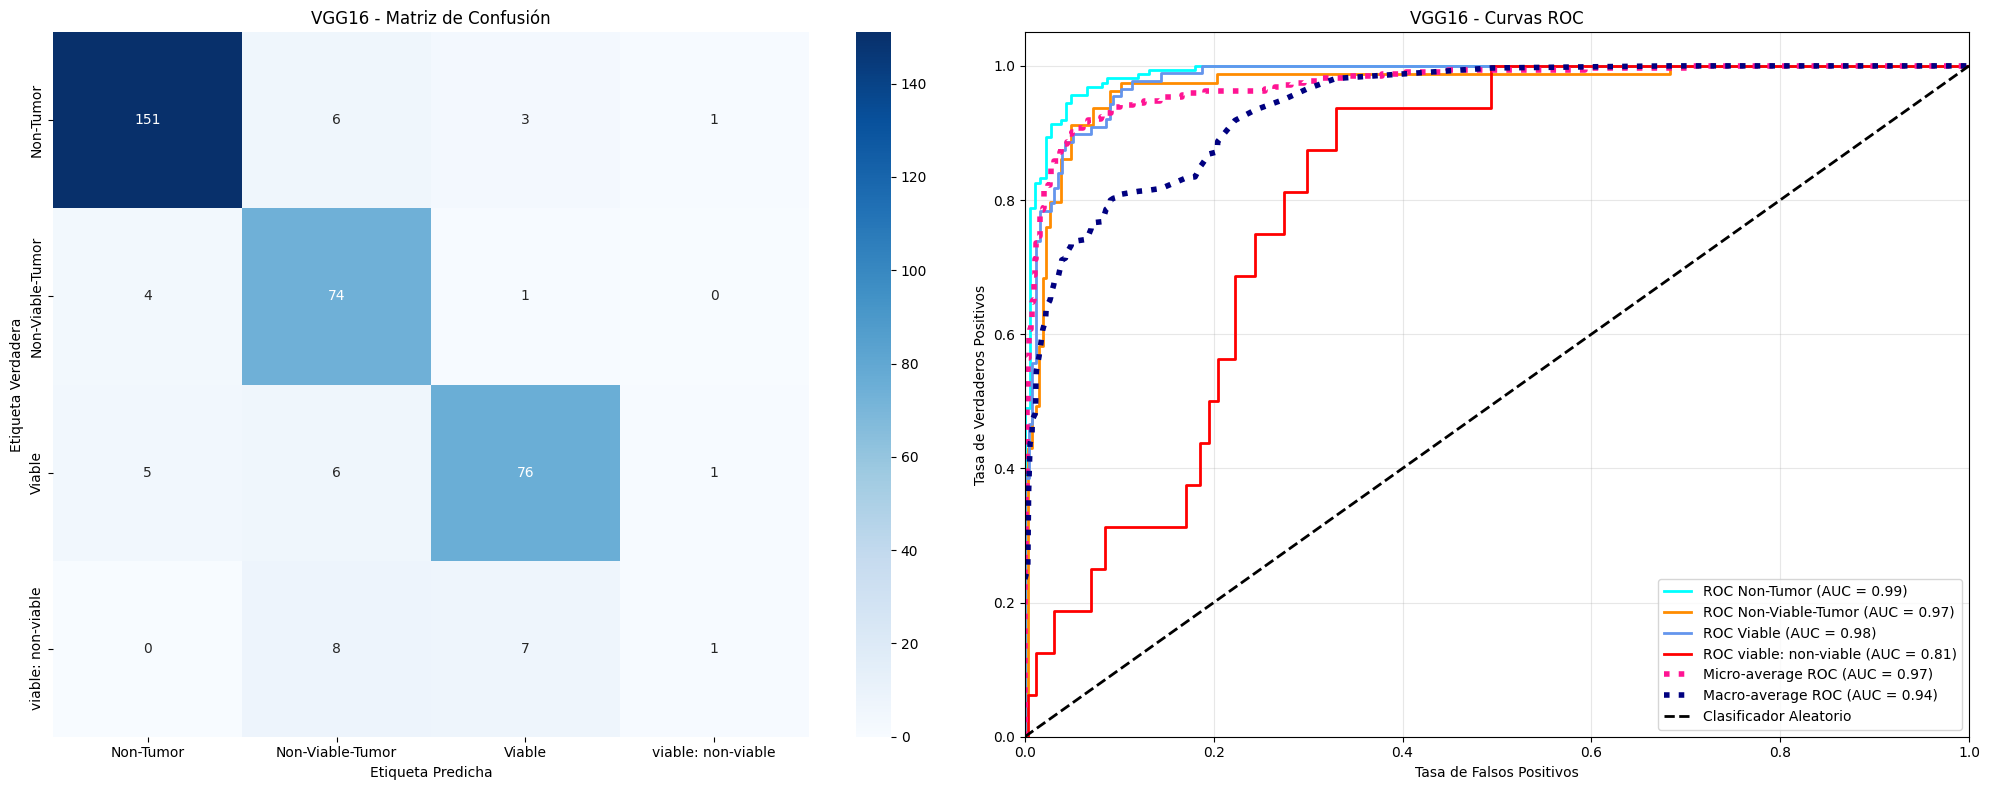


VGG16 - Coeficiente de Correlación de Matthews: 0.8156
VGG16 - AUC Macro-average: 0.9413
VGG16 - AUC Micro-average: 0.9735

Evaluando ResNet50...
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 624ms/step

ResNet50 - Accuracy: 0.8924
ResNet50 - F1-Score (Macro): 0.6804
ResNet50 - F1-Score (Weighted): 0.8728
ResNet50 - F1-Score (Micro): 0.8924
ResNet50 - F1-Score por clase:
  Non-Tumor: 0.9415
  Non-Viable-Tumor: 0.8889
  Viable: 0.8913
  viable: non-viable: 0.0000

ResNet50 - Classification Report:
                    precision    recall  f1-score   support

         Non-Tumor       0.93      0.95      0.94       161
  Non-Viable-Tumor       0.87      0.91      0.89        79
            Viable       0.85      0.93      0.89        88
viable: non-viable       0.00      0.00      0.00        16

          accuracy                           0.89       344
         macro avg       0.66      0.70      0.68       344
      weighted avg       0.85      0.89      0.87       344



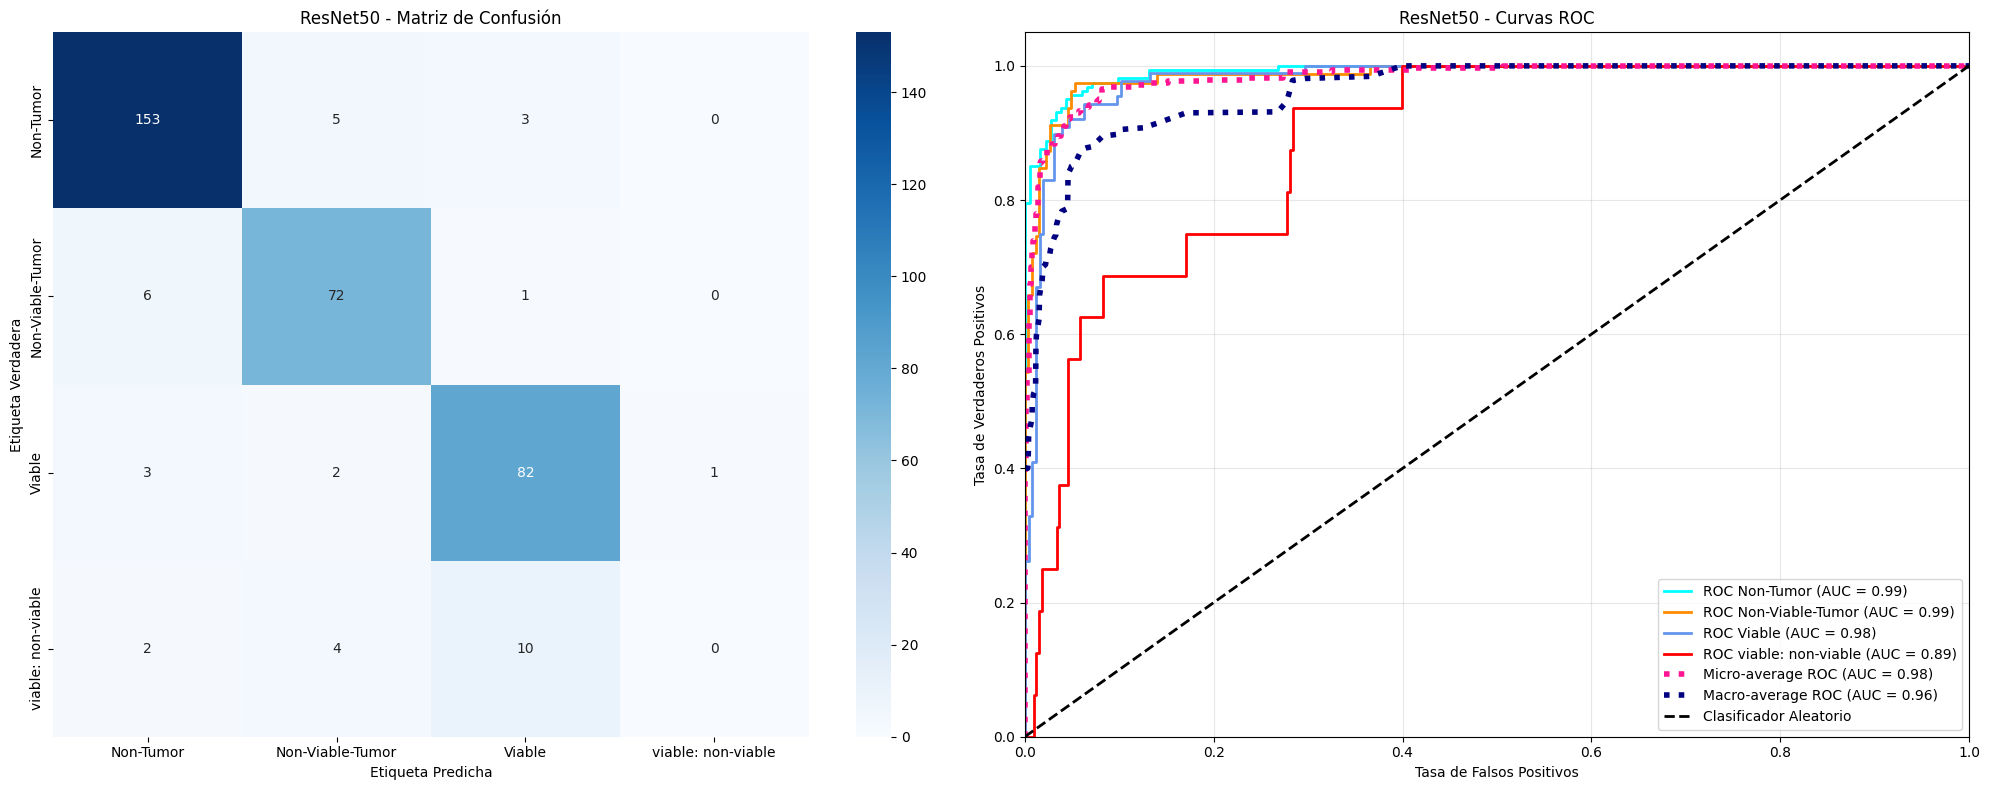


ResNet50 - Coeficiente de Correlación de Matthews: 0.8364
ResNet50 - AUC Macro-average: 0.9626
ResNet50 - AUC Micro-average: 0.9833

Evaluando MobileNetV2...
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 471ms/step

MobileNetV2 - Accuracy: 0.8779
MobileNetV2 - F1-Score (Macro): 0.6679
MobileNetV2 - F1-Score (Weighted): 0.8582
MobileNetV2 - F1-Score (Micro): 0.8779
MobileNetV2 - F1-Score por clase:
  Non-Tumor: 0.9305
  Non-Viable-Tumor: 0.8690
  Viable: 0.8721
  viable: non-viable: 0.0000

MobileNetV2 - Classification Report:
                    precision    recall  f1-score   support

         Non-Tumor       0.91      0.96      0.93       161
  Non-Viable-Tumor       0.82      0.92      0.87        79
            Viable       0.89      0.85      0.87        88
viable: non-viable       0.00      0.00      0.00        16

          accuracy                           0.88       344
         macro avg       0.65      0.68      0.67       344
      weighted avg       0.84      0.88      0.86       344



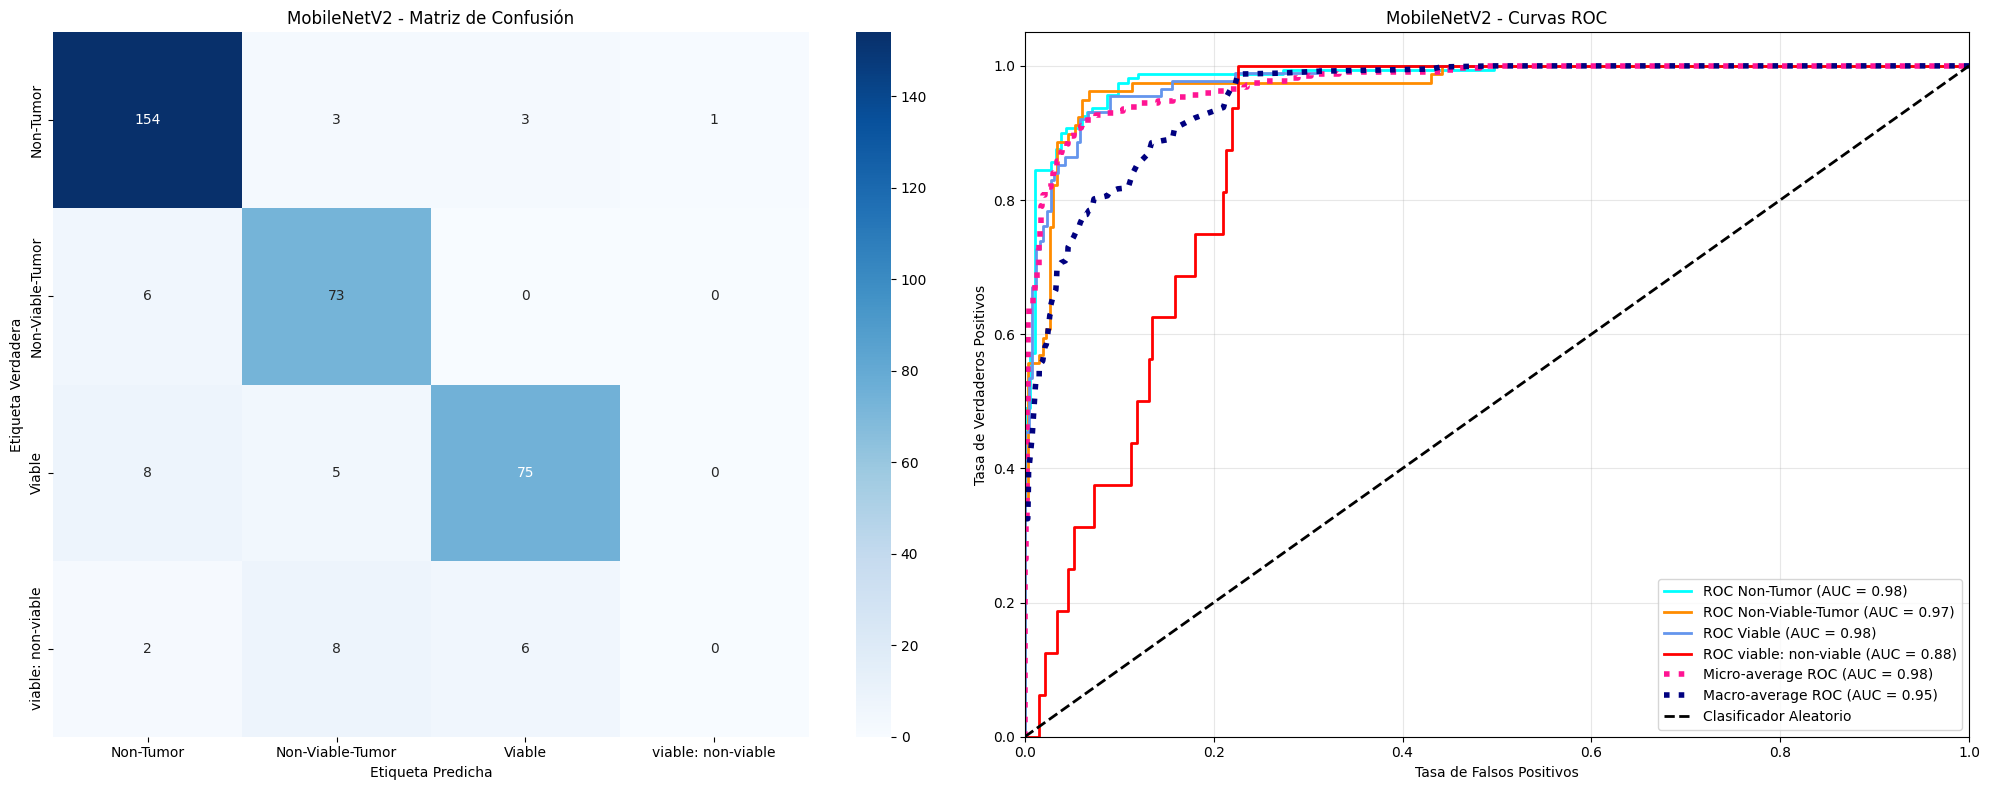


MobileNetV2 - Coeficiente de Correlación de Matthews: 0.8137
MobileNetV2 - AUC Macro-average: 0.9549
MobileNetV2 - AUC Micro-average: 0.9752

Evaluando EfficientNetB0...
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 671ms/step

EfficientNetB0 - Accuracy: 0.8808
EfficientNetB0 - F1-Score (Macro): 0.6951
EfficientNetB0 - F1-Score (Weighted): 0.8689
EfficientNetB0 - F1-Score (Micro): 0.8808
EfficientNetB0 - F1-Score por clase:
  Non-Tumor: 0.9434
  Non-Viable-Tumor: 0.8655
  Viable: 0.8764
  viable: non-viable: 0.0952

EfficientNetB0 - Classification Report:
                    precision    recall  f1-score   support

         Non-Tumor       0.96      0.93      0.94       161
  Non-Viable-Tumor       0.80      0.94      0.87        79
            Viable       0.87      0.89      0.88        88
viable: non-viable       0.20      0.06      0.10        16

          accuracy                           0.88       344
         macro avg       0.71      0.70      0.70       344
      weighted avg       0.86 

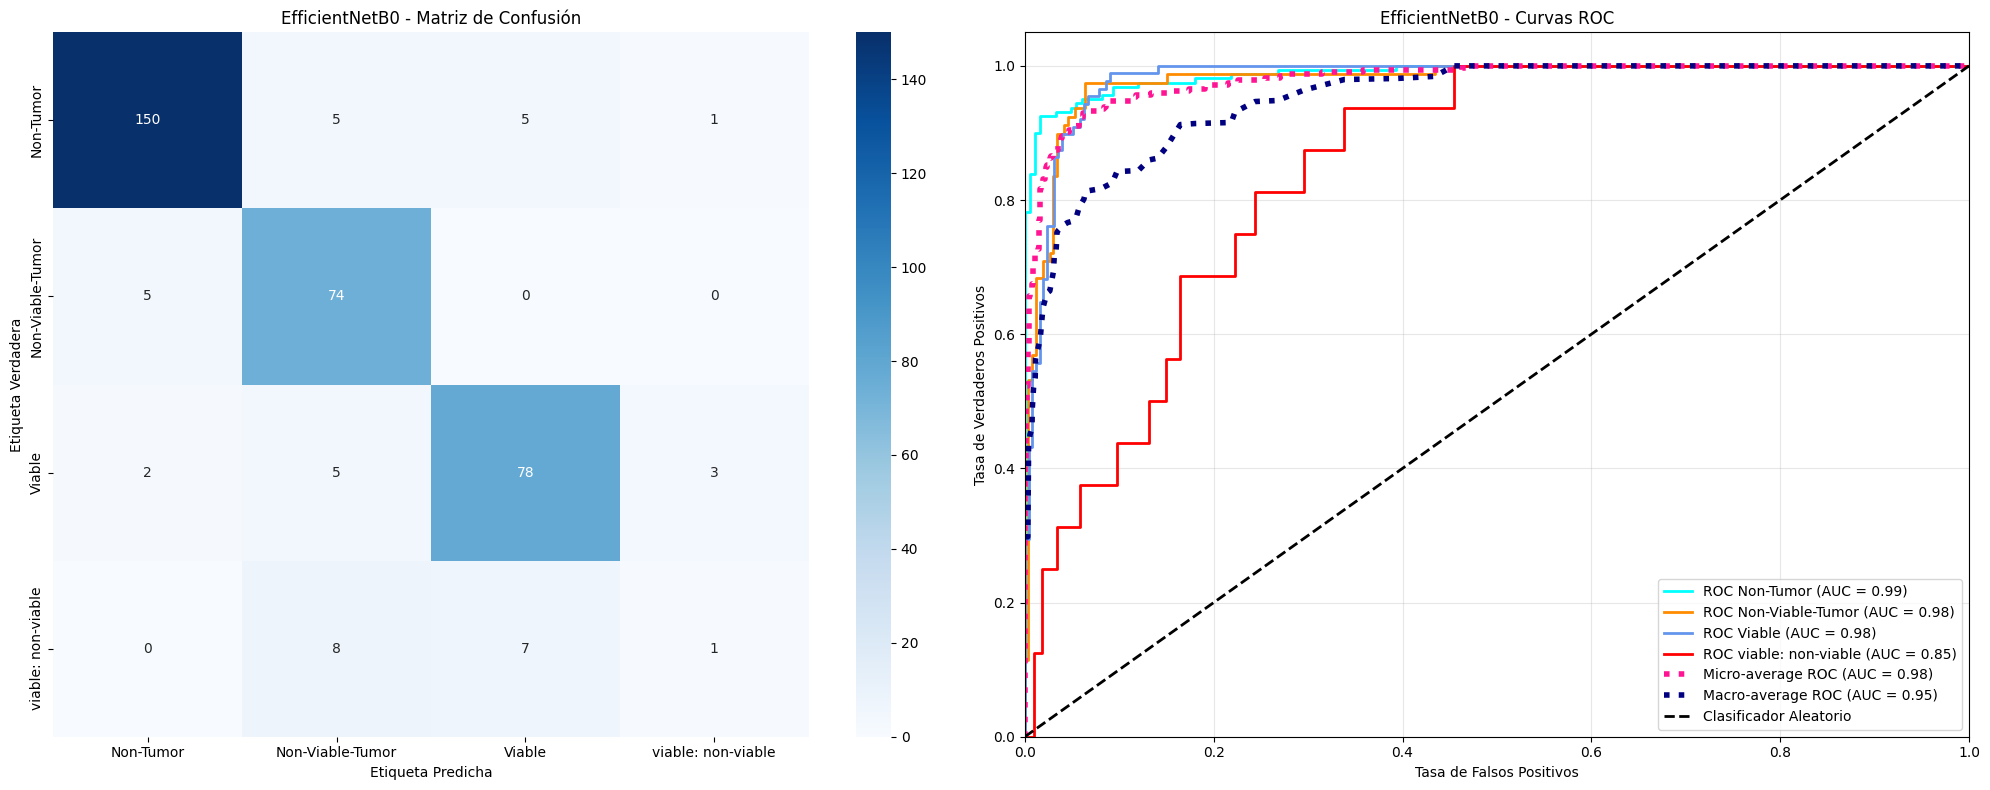


EfficientNetB0 - Coeficiente de Correlación de Matthews: 0.8203
EfficientNetB0 - AUC Macro-average: 0.9516
EfficientNetB0 - AUC Micro-average: 0.9795


In [8]:
# Función para evaluar un modelo
def evaluate_model(model, X_val, y_val, model_name, preprocessing_func=None):
    from sklearn.metrics import roc_curve, auc, f1_score
    from sklearn.preprocessing import label_binarize
    from itertools import cycle

    # Preprocesamiento para CNN estándar
    if preprocessing_func:
        X_val_processed = np.array([preprocessing_func(img) for img in X_val])
    else:
        X_val_processed = X_val / 255.0

    # Obtener predicciones
    y_pred = model.predict(X_val_processed)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Calcular métricas
    accuracy = np.mean(y_pred_classes == y_val)
    print(f"\n{model_name} - Accuracy: {accuracy:.4f}")

    # F1-score optimizado para multiclase
    # Macro: Promedio no ponderado (útil cuando las clases están desbalanceadas)
    # Weighted: Promedio ponderado por soporte (considera el desbalance de clases)
    # Micro: Calcula métricas globalmente (útil para datasets grandes)
    f1_macro = f1_score(y_val, y_pred_classes, average='macro')
    f1_weighted = f1_score(y_val, y_pred_classes, average='weighted')
    f1_micro = f1_score(y_val, y_pred_classes, average='micro')

    print(f"{model_name} - F1-Score (Macro): {f1_macro:.4f}")
    print(f"{model_name} - F1-Score (Weighted): {f1_weighted:.4f}")
    print(f"{model_name} - F1-Score (Micro): {f1_micro:.4f}")

    # F1-score por clase individual (muy útil para análisis detallado)
    f1_per_class = f1_score(y_val, y_pred_classes, average=None)
    print(f"{model_name} - F1-Score por clase:")
    for i, class_name in enumerate(label_encoder.classes_):
        print(f"  {class_name}: {f1_per_class[i]:.4f}")

    # Reporte de clasificación
    report = classification_report(y_val, y_pred_classes, target_names=label_encoder.classes_)
    print(f"\n{model_name} - Classification Report:")
    print(report)

    # Crear subplots para matriz de confusión y curvas ROC
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Matriz de confusión
    cm = confusion_matrix(y_val, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_, ax=axes[0])
    axes[0].set_title(f'{model_name} - Matriz de Confusión')
    axes[0].set_ylabel('Etiqueta Verdadera')
    axes[0].set_xlabel('Etiqueta Predicha')

    # Curvas ROC y AUC
    n_classes = len(label_encoder.classes_)

    # Binarizar las etiquetas para ROC multiclase
    y_val_bin = label_binarize(y_val, classes=range(n_classes))

    # Para casos con 4+ clases, label_binarize devuelve una matriz 2D
    # Para casos con 2 clases, devuelve un vector 1D que necesita ser reformateado
    if n_classes == 2:
        y_val_bin = np.column_stack([1 - y_val_bin, y_val_bin])

    # Calcular ROC curve y AUC para cada clase
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular micro-average ROC curve y AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Calcular macro-average ROC curve y AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plotear ROC curves
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple'])

    # Plotear curva ROC para cada clase
    for i, color in zip(range(n_classes), colors):
        axes[1].plot(fpr[i], tpr[i], color=color, lw=2,
                    label=f'ROC {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

    # Plotear micro y macro average
    axes[1].plot(fpr["micro"], tpr["micro"],
                label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.2f})',
                color='deeppink', linestyle=':', linewidth=4)

    axes[1].plot(fpr["macro"], tpr["macro"],
                label=f'Macro-average ROC (AUC = {roc_auc["macro"]:.2f})',
                color='navy', linestyle=':', linewidth=4)

    # Línea diagonal (clasificador aleatorio)
    axes[1].plot([0, 1], [0, 1], 'k--', lw=2, label='Clasificador Aleatorio')

    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('Tasa de Falsos Positivos')
    axes[1].set_ylabel('Tasa de Verdaderos Positivos')
    axes[1].set_title(f'{model_name} - Curvas ROC')
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{model_name}_evaluation_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Coeficiente de Matthews (especialmente útil para datasets desbalanceados)
    mcc = matthews_corrcoef(y_val, y_pred_classes)
    print(f"\n{model_name} - Coeficiente de Correlación de Matthews: {mcc:.4f}")
    print(f"{model_name} - AUC Macro-average: {roc_auc['macro']:.4f}")
    print(f"{model_name} - AUC Micro-average: {roc_auc['micro']:.4f}")

    return y_pred_classes, y_pred, roc_auc, f1_per_class

# Evaluar todos los modelos
predictions = {}
probabilities = {}
auc_scores = {}
f1_per_class_scores = {}

for name, model in models.items():
    print(f"\nEvaluando {name}...")

    if name == 'VGG16':
        pred_classes, pred_probs, roc_auc, f1_classes = evaluate_model(model, X_val, y_val, name, preprocessing_func=vgg_preprocess)
    elif name == 'ResNet50':
        pred_classes, pred_probs, roc_auc, f1_classes = evaluate_model(model, X_val, y_val, name, preprocessing_func=resnet_preprocess)
    elif name == 'MobileNetV2':
        pred_classes, pred_probs, roc_auc, f1_classes = evaluate_model(model, X_val, y_val, name, preprocessing_func=mobilenet_preprocess)
    elif name == 'EfficientNetB0':
        pred_classes, pred_probs, roc_auc, f1_classes = evaluate_model(model, X_val, y_val, name, preprocessing_func=efficientnet_preprocess)
    else:
        pred_classes, pred_probs, roc_auc, f1_classes = evaluate_model(model, X_val, y_val, name)

    predictions[name] = pred_classes
    probabilities[name] = pred_probs
    auc_scores[name] = roc_auc
    f1_per_class_scores[name] = f1_classes

### Resumen comparativo de todas las métricas

RESUMEN COMPARATIVO DE MODELOS
        Modelo  Accuracy  F1-Score (Macro)  F1-Score (Weighted)  F1-Score (Micro)  AUC (Macro)  AUC (Micro)    MCC
         VGG16    0.8779            0.6925               0.8639            0.8779       0.9413       0.9735 0.8156
      ResNet50    0.8924            0.6804               0.8728            0.8924       0.9626       0.9833 0.8364
   MobileNetV2    0.8779            0.6679               0.8582            0.8779       0.9549       0.9752 0.8137
EfficientNetB0    0.8808            0.6951               0.8689            0.8808       0.9516       0.9795 0.8203


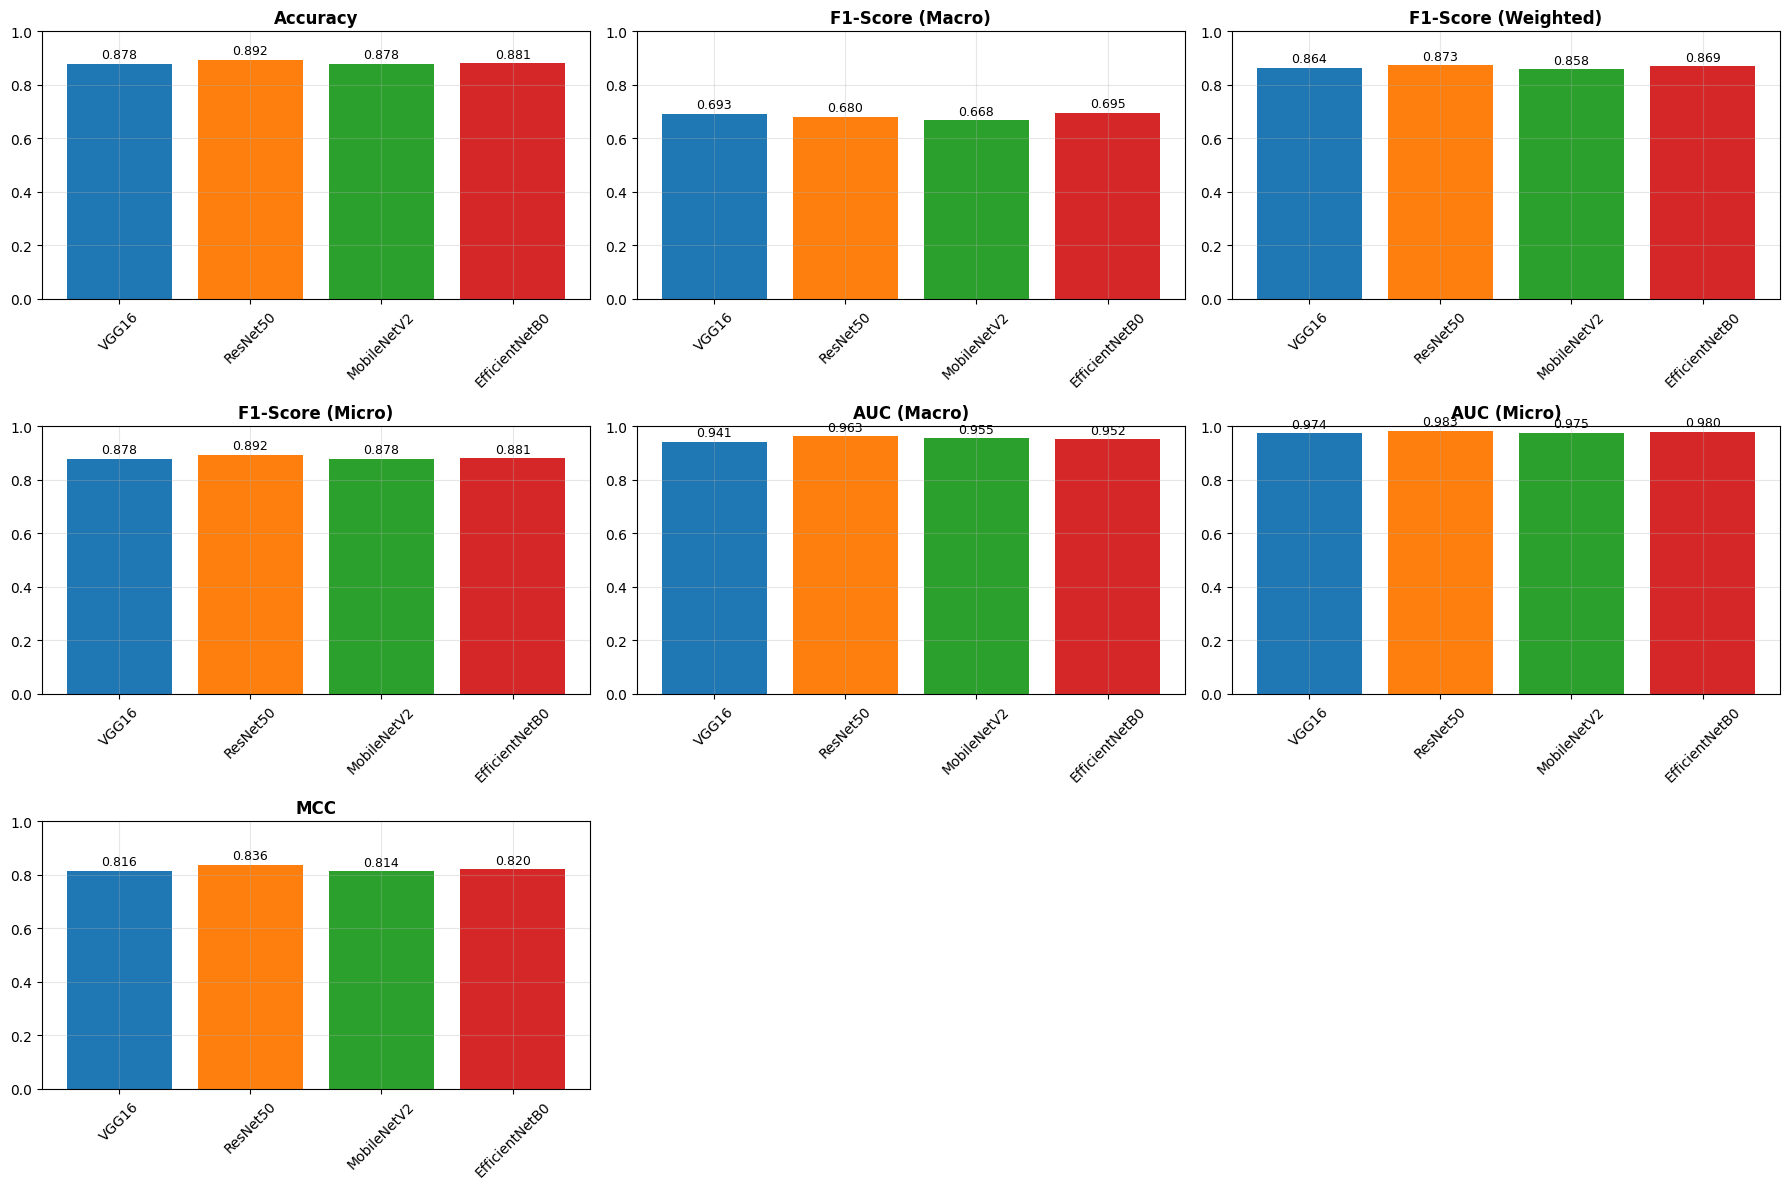


ANÁLISIS F1-SCORE POR CLASE


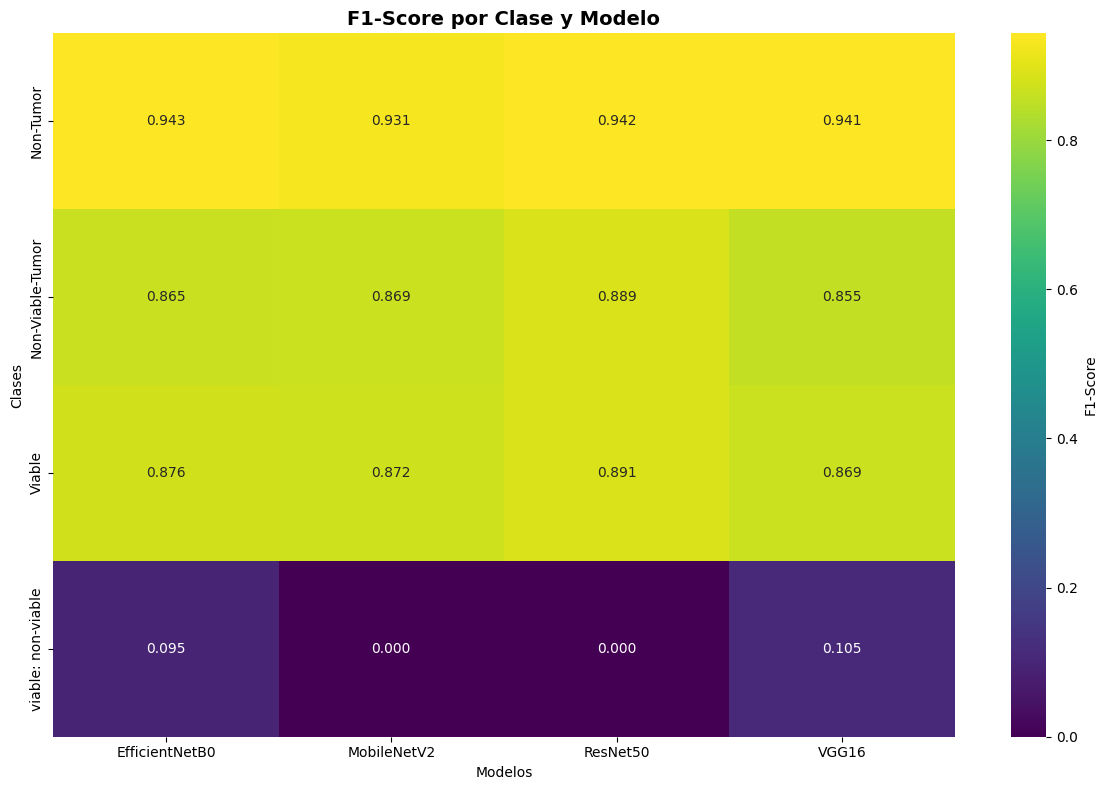


MEJORES MODELOS POR MÉTRICA
Accuracy            : ResNet50        (0.8924)
F1-Score (Macro)    : EfficientNetB0  (0.6951)
F1-Score (Weighted) : ResNet50        (0.8728)
F1-Score (Micro)    : ResNet50        (0.8924)
AUC (Macro)         : ResNet50        (0.9626)
AUC (Micro)         : ResNet50        (0.9833)
MCC                 : ResNet50        (0.8364)

MEJORES MODELOS POR CLASE (F1-Score)
Non-Tumor           : EfficientNetB0  (0.9434)
Non-Viable-Tumor    : ResNet50        (0.8889)
Viable              : ResNet50        (0.8913)
viable: non-viable  : VGG16           (0.1053)



In [9]:
from sklearn.metrics import accuracy_score, f1_score

print("="*80)
print("RESUMEN COMPARATIVO DE MODELOS")
print("="*80)

# Crear tabla resumen
summary_data = []
for name in models.keys():
    pred_classes = predictions[name]
    auc_macro = auc_scores[name]['macro']
    auc_micro = auc_scores[name]['micro']

    accuracy = accuracy_score(y_val, pred_classes)
    f1_macro = f1_score(y_val, pred_classes, average='macro')
    f1_weighted = f1_score(y_val, pred_classes, average='weighted')
    f1_micro = f1_score(y_val, pred_classes, average='micro')
    mcc = matthews_corrcoef(y_val, pred_classes)

    summary_data.append({
        'Modelo': name,
        'Accuracy': accuracy,
        'F1-Score (Macro)': f1_macro,
        'F1-Score (Weighted)': f1_weighted,
        'F1-Score (Micro)': f1_micro,
        'AUC (Macro)': auc_macro,
        'AUC (Micro)': auc_micro,
        'MCC': mcc
    })

# Convertir a DataFrame para mejor visualización
summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.round(4)

print(summary_df.to_string(index=False))

# Crear gráfico comparativo de métricas
plt.figure(figsize=(18, 12))

metrics = ['Accuracy', 'F1-Score (Macro)', 'F1-Score (Weighted)', 'F1-Score (Micro)', 'AUC (Macro)', 'AUC (Micro)', 'MCC']
x_pos = np.arange(len(models))
width = 0.15

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, metric in enumerate(metrics):
    plt.subplot(3, 3, i+1)
    values = [summary_df[summary_df['Modelo'] == name][metric].iloc[0] for name in models.keys()]
    bars = plt.bar(x_pos, values, color=colors)

    plt.title(f'{metric}', fontsize=12, fontweight='bold')
    plt.xticks(x_pos, models.keys(), rotation=45)
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)

    # Añadir valores en las barras
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('models_comparison_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# Análisis detallado por clase
print("\n" + "="*80)
print("ANÁLISIS F1-SCORE POR CLASE")
print("="*80)

# Crear DataFrame para F1-scores por clase
class_f1_data = []
for model_name in models.keys():
    for i, class_name in enumerate(label_encoder.classes_):
        class_f1_data.append({
            'Modelo': model_name,
            'Clase': class_name,
            'F1-Score': f1_per_class_scores[model_name][i]
        })

class_f1_df = pd.DataFrame(class_f1_data)

# Crear heatmap de F1-scores por clase
plt.figure(figsize=(12, 8))
pivot_df = class_f1_df.pivot(index='Clase', columns='Modelo', values='F1-Score')
sns.heatmap(pivot_df, annot=True, cmap='viridis', fmt='.3f', cbar_kws={'label': 'F1-Score'})
plt.title('F1-Score por Clase y Modelo', fontsize=14, fontweight='bold')
plt.ylabel('Clases')
plt.xlabel('Modelos')
plt.tight_layout()
plt.savefig('f1_score_by_class_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Encontrar el mejor modelo por cada métrica
print("\n" + "="*50)
print("MEJORES MODELOS POR MÉTRICA")
print("="*50)

for metric in metrics:
    best_model_idx = summary_df[metric].idxmax()
    best_model = summary_df.loc[best_model_idx, 'Modelo']
    best_value = summary_df.loc[best_model_idx, metric]
    print(f"{metric:20s}: {best_model:15s} ({best_value:.4f})")

# Encontrar el mejor modelo por clase
print("\n" + "="*50)
print("MEJORES MODELOS POR CLASE (F1-Score)")
print("="*50)

for class_name in label_encoder.classes_:
    class_scores = class_f1_df[class_f1_df['Clase'] == class_name]
    best_idx = class_scores['F1-Score'].idxmax()
    best_model = class_scores.loc[best_idx, 'Modelo']
    best_score = class_scores.loc[best_idx, 'F1-Score']
    print(f"{class_name:20s}: {best_model:15s} ({best_score:.4f})")

print("\n" + "="*80)

### Métricas adicionales que podrían ser de utilidad en aplicaciones médicas

MÉTRICAS ADICIONALES PARA MODELOS MÉDICOS
MÉTRICAS ADICIONALES:
        Modelo  Balanced Accuracy  Cohen Kappa  Log Loss  Top-2 Accuracy  Precision (Macro)  Recall (Macro)  Specificity (Macro)
         VGG16             0.7002       0.8134    0.4291          0.9419             0.7345          0.7002               0.9566
      ResNet50             0.6984       0.8345    0.3017          0.9709             0.6636          0.6984               0.9602
   MobileNetV2             0.6832       0.8112    0.3749          0.9622             0.6547          0.6832               0.9535
EfficientNetB0             0.7043       0.8187    0.3376          0.9535             0.7066          0.7043               0.9587


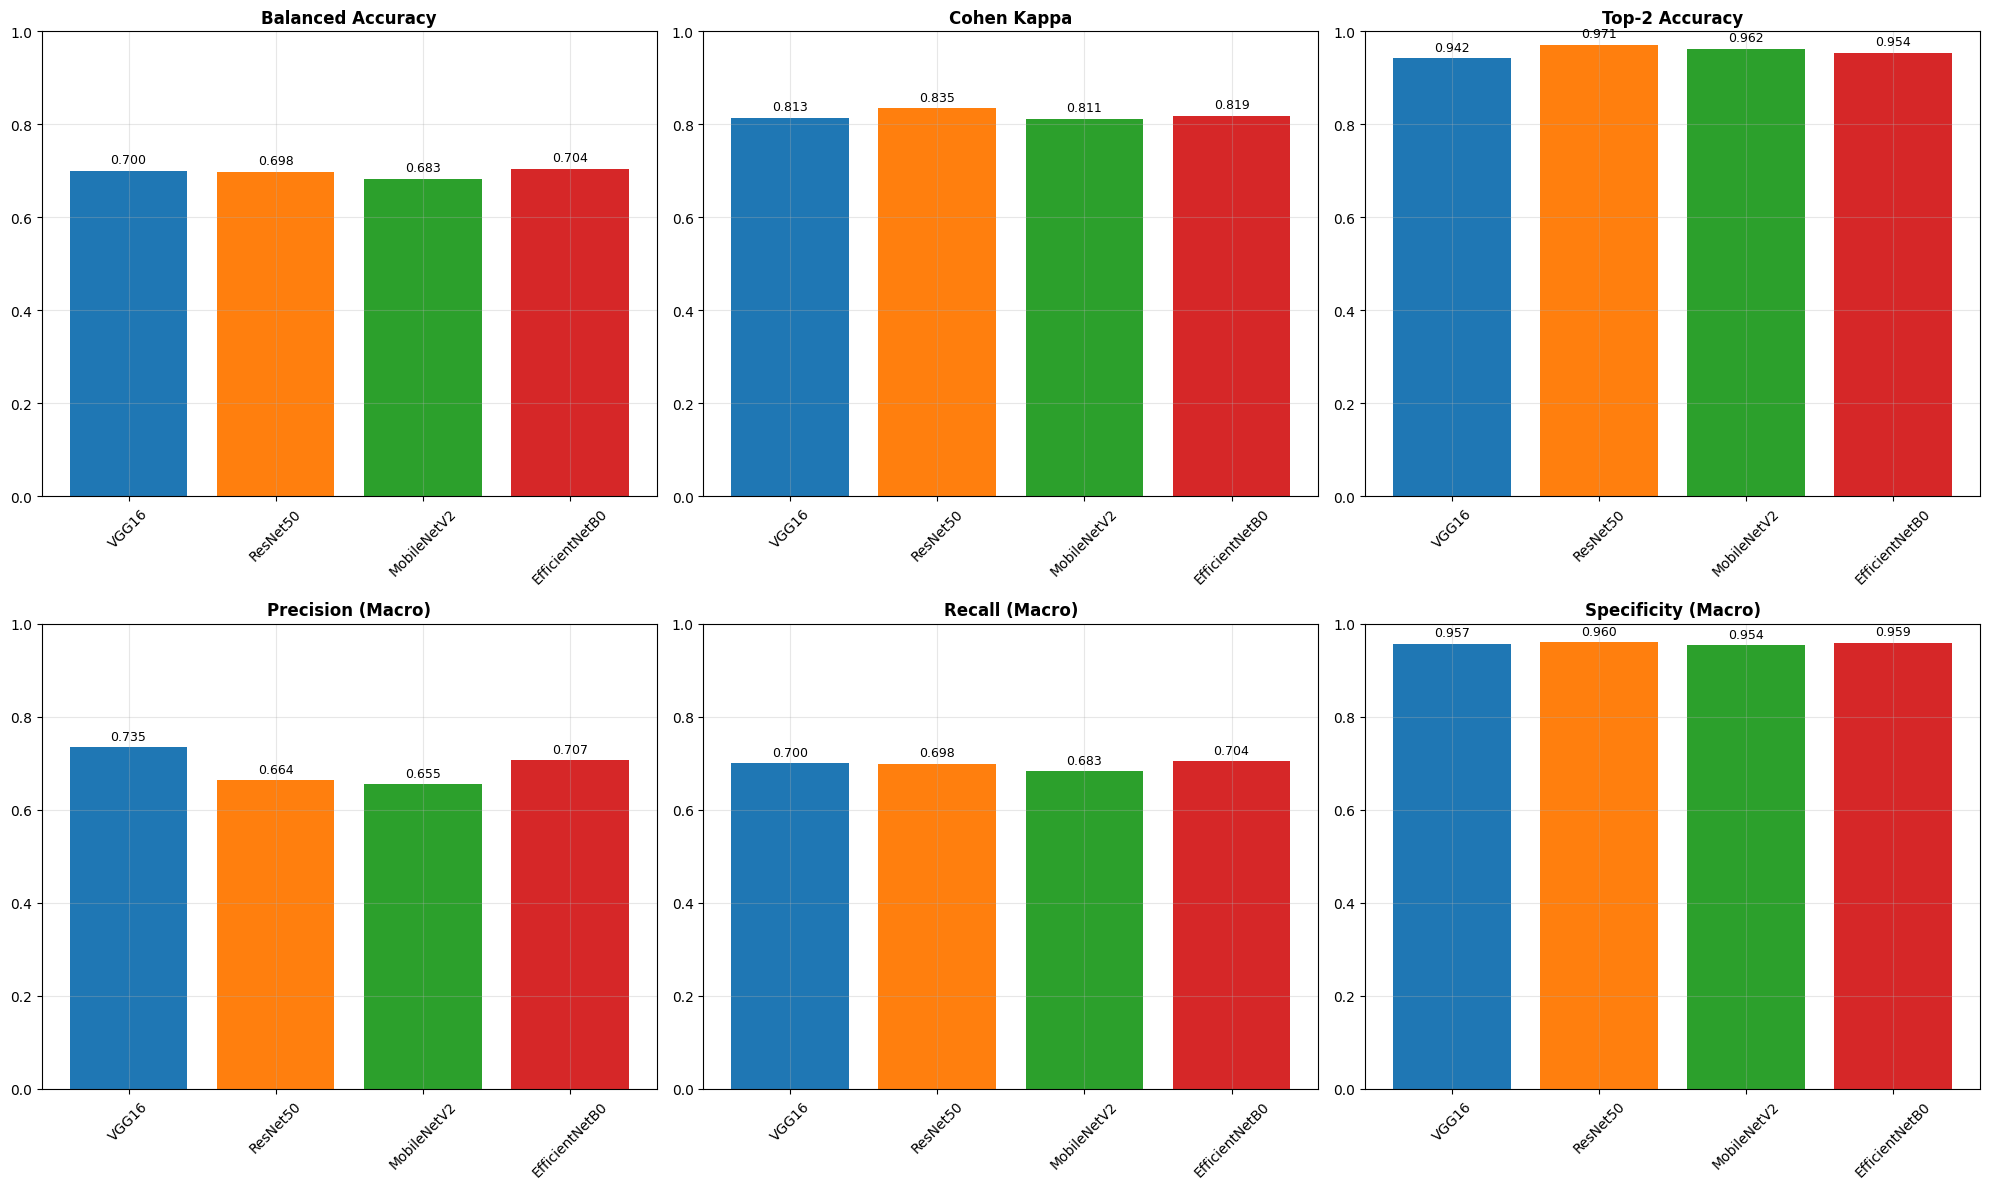


ANÁLISIS DE SENSIBILIDAD Y ESPECIFICIDAD POR CLASE


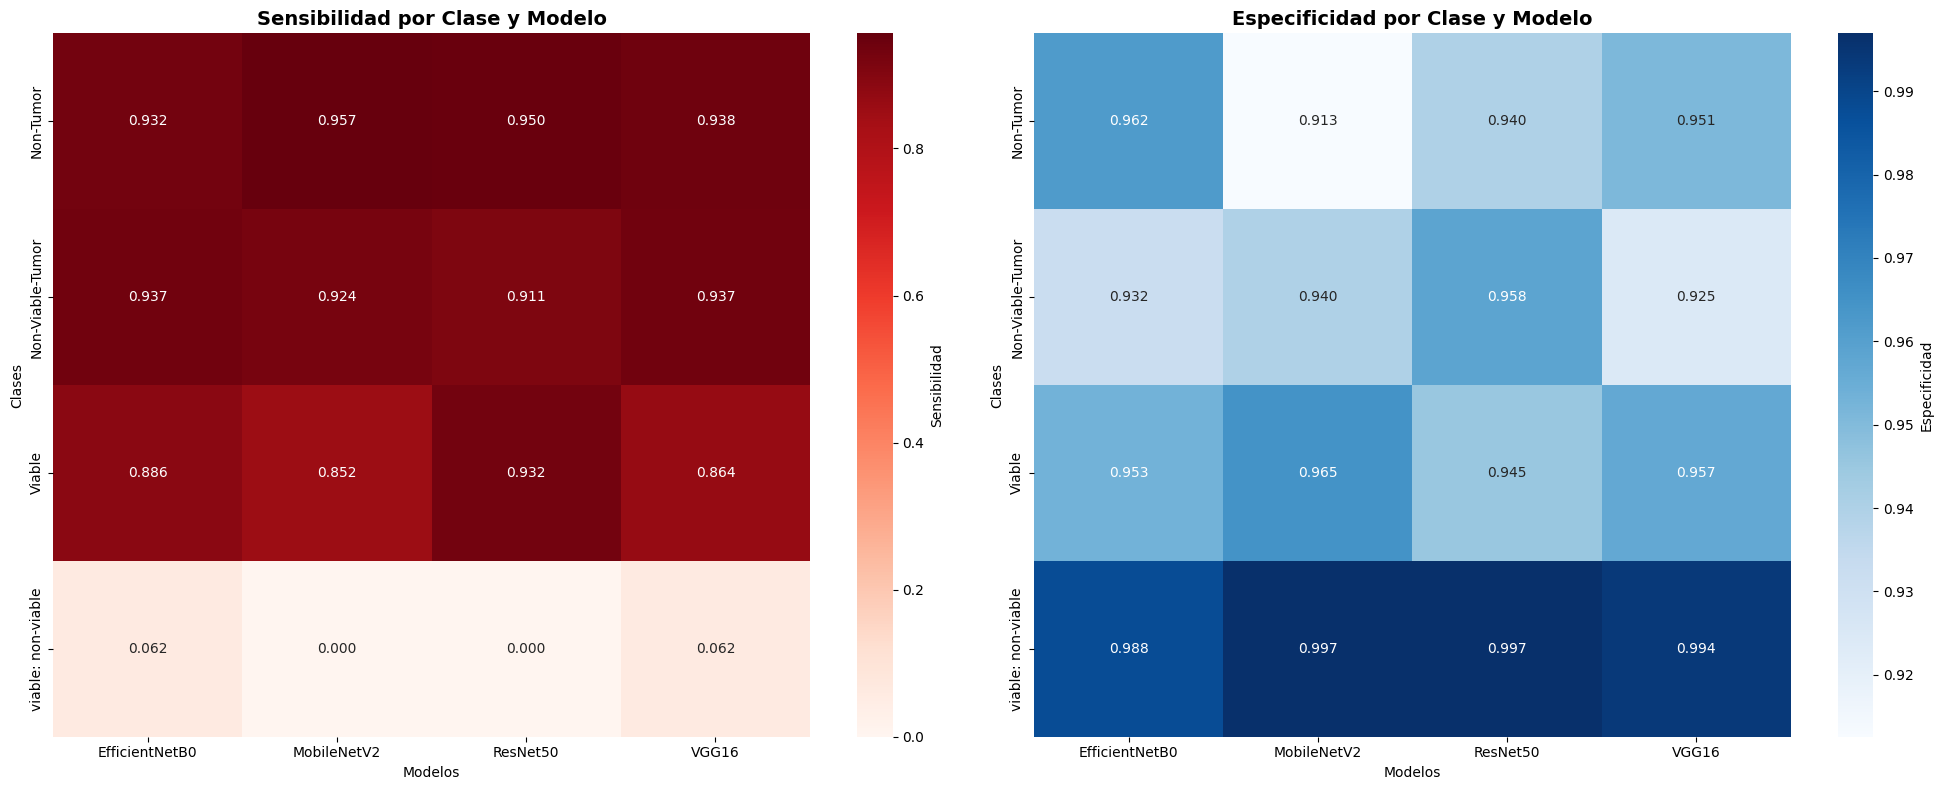


EXPLICACIÓN DE MÉTRICAS PARA MODELOS MÉDICOS

🎯 MÉTRICAS CLAVE PARA CLASIFICACIÓN MÉDICA MULTICLASE:

1. BALANCED ACCURACY: 
   - Promedio de recall de cada clase
   - Ideal para datos desbalanceados como el nuestro
   - Valor óptimo: cercano a 1.0

2. COHEN'S KAPPA:
   - Mide concordancia corrigiendo el azar
   - 0.0 = acuerdo casual, 1.0 = acuerdo perfecto
   - >0.8 = excelente, >0.6 = bueno

3. LOG LOSS:
   - Penaliza predicciones incorrectas con alta confianza
   - Valor óptimo: cercano a 0.0
   - Importante en diagnóstico médico (evita sobre-confianza)

4. TOP-2 ACCURACY:
   - % de casos donde la clase correcta está en top 2 predicciones
   - Útil en diagnóstico diferencial
   - Valor óptimo: >0.9

5. SENSIBILIDAD (RECALL):
   - Capacidad de detectar casos positivos
   - Crítica para detectar casos de cáncer
   - TP / (TP + FN)

6. ESPECIFICIDAD:
   - Capacidad de evitar falsos positivos
   - Importante para evitar diagnósticos erróneos
   - TN / (TN + FP)

🏥 CONSIDERACIONES MÉDI

In [10]:
from sklearn.metrics import (
    balanced_accuracy_score,
    cohen_kappa_score,
    log_loss,
    precision_recall_fscore_support,
    top_k_accuracy_score
)

print("="*80)
print("MÉTRICAS ADICIONALES PARA MODELOS MÉDICOS")
print("="*80)

# Calcular métricas adicionales para cada modelo
additional_metrics = []

for name in models.keys():
    pred_classes = predictions[name]
    pred_probs = probabilities[name]

    # 1. Balanced Accuracy: Especialmente importante para datos desbalanceados
    balanced_acc = balanced_accuracy_score(y_val, pred_classes)

    # 2. Cohen's Kappa: Mide concordancia considerando el azar
    kappa = cohen_kappa_score(y_val, pred_classes)

    # 3. Log Loss: Penaliza predicciones incorrectas con alta confianza
    logloss = log_loss(y_val, pred_probs)

    # 4. Top-2 Accuracy: Útil en diagnóstico médico (si la clase correcta está en top 2)
    top2_acc = top_k_accuracy_score(y_val, pred_probs, k=2)

    # 5. Precisión, Recall y F1 por clase (macro avg)
    precision, recall, f1, support = precision_recall_fscore_support(
        y_val, pred_classes, average='macro'
    )

    # 6. Especificidad promedio (importante en diagnóstico médico)
    # Calcular especificidad para cada clase
    cm = confusion_matrix(y_val, pred_classes)
    specificities = []

    for i in range(len(label_encoder.classes_)):
        # Para clase i: especificidad = TN / (TN + FP)
        tn = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
        fp = np.sum(cm[:, i]) - cm[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificities.append(specificity)

    avg_specificity = np.mean(specificities)

    additional_metrics.append({
        'Modelo': name,
        'Balanced Accuracy': balanced_acc,
        'Cohen Kappa': kappa,
        'Log Loss': logloss,
        'Top-2 Accuracy': top2_acc,
        'Precision (Macro)': precision,
        'Recall (Macro)': recall,
        'Specificity (Macro)': avg_specificity
    })

# Crear DataFrame para métricas adicionales
additional_df = pd.DataFrame(additional_metrics)
additional_df = additional_df.round(4)

print("MÉTRICAS ADICIONALES:")
print(additional_df.to_string(index=False))

# Visualización de métricas adicionales
plt.figure(figsize=(20, 12))

additional_metrics_names = [
    'Balanced Accuracy', 'Cohen Kappa', 'Top-2 Accuracy',
    'Precision (Macro)', 'Recall (Macro)', 'Specificity (Macro)'
]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
x_pos = np.arange(len(models))

for i, metric in enumerate(additional_metrics_names):
    plt.subplot(2, 3, i+1)
    values = [additional_df[additional_df['Modelo'] == name][metric].iloc[0] for name in models.keys()]
    bars = plt.bar(x_pos, values, color=colors)

    plt.title(f'{metric}', fontsize=12, fontweight='bold')
    plt.xticks(x_pos, models.keys(), rotation=45)

    # Ajustar ylim según la métrica
    if metric == 'Log Loss':
        plt.ylim(0, max(values) * 1.1)
    else:
        plt.ylim(0, 1)

    plt.grid(True, alpha=0.3)

    # Añadir valores en las barras
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('additional_medical_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# Análisis de sensibilidad y especificidad por clase
print("\n" + "="*80)
print("ANÁLISIS DE SENSIBILIDAD Y ESPECIFICIDAD POR CLASE")
print("="*80)

sensitivity_specificity_data = []

for model_name in models.keys():
    pred_classes = predictions[model_name]
    cm = confusion_matrix(y_val, pred_classes)

    for i, class_name in enumerate(label_encoder.classes_):
        # Sensibilidad (Recall) = TP / (TP + FN)
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

        # Especificidad = TN / (TN + FP)
        tn = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
        fp = np.sum(cm[:, i]) - tp
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        sensitivity_specificity_data.append({
            'Modelo': model_name,
            'Clase': class_name,
            'Sensibilidad': sensitivity,
            'Especificidad': specificity
        })

sens_spec_df = pd.DataFrame(sensitivity_specificity_data)

# Crear heatmaps para sensibilidad y especificidad
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Heatmap de Sensibilidad
sens_pivot = sens_spec_df.pivot(index='Clase', columns='Modelo', values='Sensibilidad')
sns.heatmap(sens_pivot, annot=True, cmap='Reds', fmt='.3f',
            cbar_kws={'label': 'Sensibilidad'}, ax=axes[0])
axes[0].set_title('Sensibilidad por Clase y Modelo', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Clases')
axes[0].set_xlabel('Modelos')

# Heatmap de Especificidad
spec_pivot = sens_spec_df.pivot(index='Clase', columns='Modelo', values='Especificidad')
sns.heatmap(spec_pivot, annot=True, cmap='Blues', fmt='.3f',
            cbar_kws={'label': 'Especificidad'}, ax=axes[1])
axes[1].set_title('Especificidad por Clase y Modelo', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Clases')
axes[1].set_xlabel('Modelos')

plt.tight_layout()
plt.savefig('sensitivity_specificity_heatmaps.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("EXPLICACIÓN DE MÉTRICAS PARA MODELOS MÉDICOS")
print("="*80)
print("""
🎯 MÉTRICAS CLAVE PARA CLASIFICACIÓN MÉDICA MULTICLASE:

1. BALANCED ACCURACY:
   - Promedio de recall de cada clase
   - Ideal para datos desbalanceados como el nuestro
   - Valor óptimo: cercano a 1.0

2. COHEN'S KAPPA:
   - Mide concordancia corrigiendo el azar
   - 0.0 = acuerdo casual, 1.0 = acuerdo perfecto
   - >0.8 = excelente, >0.6 = bueno

3. LOG LOSS:
   - Penaliza predicciones incorrectas con alta confianza
   - Valor óptimo: cercano a 0.0
   - Importante en diagnóstico médico (evita sobre-confianza)

4. TOP-2 ACCURACY:
   - % de casos donde la clase correcta está en top 2 predicciones
   - Útil en diagnóstico diferencial
   - Valor óptimo: >0.9

5. SENSIBILIDAD (RECALL):
   - Capacidad de detectar casos positivos
   - Crítica para detectar casos de cáncer
   - TP / (TP + FN)

6. ESPECIFICIDAD:
   - Capacidad de evitar falsos positivos
   - Importante para evitar diagnósticos erróneos
   - TN / (TN + FP)

🏥 CONSIDERACIONES MÉDICAS:
- En cáncer: SENSIBILIDAD alta es crítica (no perder casos)
- En diagnóstico: ESPECIFICIDAD alta evita tratamientos innecesarios
- BALANCED ACCURACY es mejor que accuracy simple en datos desbalanceados
- COHEN'S KAPPA considera el azar (importante en múltiples clases)
""")

# Ranking consolidado considerando todas las métricas
print("\n" + "="*50)
print("RANKING CONSOLIDADO DE MODELOS")
print("="*50)

# Combinar todas las métricas (normalizadas)
consolidated_data = []
for name in models.keys():
    # Métricas principales (a maximizar)
    main_row = summary_df[summary_df['Modelo'] == name].iloc[0]
    add_row = additional_df[additional_df['Modelo'] == name].iloc[0]

    # Normalizar Log Loss (a minimizar) -> 1 - normalized_log_loss
    max_log_loss = additional_df['Log Loss'].max()
    normalized_log_loss = 1 - (add_row['Log Loss'] / max_log_loss)

    score = (
        main_row['F1-Score (Macro)'] * 0.20 +      # F1 Macro (importante para balance)
        main_row['F1-Score (Weighted)'] * 0.15 +   # F1 Weighted
        add_row['Balanced Accuracy'] * 0.20 +      # Balanced Accuracy (clave en desbalance)
        add_row['Cohen Kappa'] * 0.15 +            # Kappa (concordancia)
        main_row['MCC'] * 0.10 +                   # MCC (correlación)
        add_row['Top-2 Accuracy'] * 0.10 +         # Top-2 (diagnóstico diferencial)
        normalized_log_loss * 0.10                 # Log Loss normalizado
    )

    consolidated_data.append({
        'Modelo': name,
        'Score Consolidado': score
    })

consolidated_df = pd.DataFrame(consolidated_data)
consolidated_df = consolidated_df.sort_values('Score Consolidado', ascending=False)
consolidated_df['Score Consolidado'] = consolidated_df['Score Consolidado'].round(4)

print("RANKING FINAL (Score Consolidado):")
for i, row in consolidated_df.iterrows():
    print(f"{row.name+1:2d}. {row['Modelo']:15s}: {row['Score Consolidado']:.4f}")

print("\n" + "="*80)

### Prueba de McNemar para comparación de modelos

In [11]:
# Función para realizar la prueba de McNemar
def mcnemar_test(model1_preds, model2_preds, y_true, model1_name, model2_name):
    # Crear tabla de contingencia
    correct1 = model1_preds == y_true
    correct2 = model2_preds == y_true

    # Tabla: [correcto/correcto, correcto/incorrecto, incorrecto/correcto, incorrecto/incorrecto]
    table = np.zeros((2, 2))
    table[0, 0] = np.sum(correct1 & correct2)  # Ambos correctos
    table[0, 1] = np.sum(correct1 & ~correct2)  # Modelo 1 correcto, Modelo 2 incorrecto
    table[1, 0] = np.sum(~correct1 & correct2)  # Modelo 1 incorrecto, Modelo 2 correcto
    table[1, 1] = np.sum(~correct1 & ~correct2)  # Ambos incorrectos

    # Realizar la prueba de McNemar
    result = mcnemar(table, exact=True)

    print(f"\nPrueba de McNemar: {model1_name} vs {model2_name}")
    print(f"Tabla de contingencia:")
    print(f"                    | {model2_name} correcto | {model2_name} incorrecto")
    print(f"--------------------|---------------------|----------------------")
    print(f"{model1_name} correcto   | {table[0, 0]:.0f}                | {table[0, 1]:.0f}")
    print(f"{model1_name} incorrecto | {table[1, 0]:.0f}                | {table[1, 1]:.0f}")
    print(f"\nEstadístico: {result.statistic:.4f}")
    print(f"P-valor: {result.pvalue:.4f}")

    if result.pvalue < 0.05:
        print(f"Conclusión: Hay una diferencia estadísticamente significativa entre {model1_name} y {model2_name}.")
    else:
        print(f"Conclusión: No hay una diferencia estadísticamente significativa entre {model1_name} y {model2_name}.")

# Realizar la prueba de McNemar para cada par de modelos
model_names = list(models.keys())
for i in range(len(model_names)):
    for j in range(i+1, len(model_names)):
        mcnemar_test(
            predictions[model_names[i]],
            predictions[model_names[j]],
            y_val,
            model_names[i],
            model_names[j]
        )


Prueba de McNemar: VGG16 vs ResNet50
Tabla de contingencia:
                    | ResNet50 correcto | ResNet50 incorrecto
--------------------|---------------------|----------------------
VGG16 correcto   | 294                | 8
VGG16 incorrecto | 13                | 29

Estadístico: 8.0000
P-valor: 0.3833
Conclusión: No hay una diferencia estadísticamente significativa entre VGG16 y ResNet50.

Prueba de McNemar: VGG16 vs MobileNetV2
Tabla de contingencia:
                    | MobileNetV2 correcto | MobileNetV2 incorrecto
--------------------|---------------------|----------------------
VGG16 correcto   | 288                | 14
VGG16 incorrecto | 14                | 28

Estadístico: 14.0000
P-valor: 1.0000
Conclusión: No hay una diferencia estadísticamente significativa entre VGG16 y MobileNetV2.

Prueba de McNemar: VGG16 vs EfficientNetB0
Tabla de contingencia:
                    | EfficientNetB0 correcto | EfficientNetB0 incorrecto
--------------------|---------------------|----

### Código de ejemplo para inferencia con los modelos entrenados

In [12]:
# Función para cargar un modelo y realizar inferencia
def load_model_and_predict(model_path, image_path, class_mapping, model_type=None):
    # Cargar imagen
    img = Image.open(image_path)
    img = img.resize((224, 224))
    img_array = np.array(img)

    # Asegurarse de que la imagen tiene 3 canales
    if len(img_array.shape) == 2:
        img_array = np.stack([img_array, img_array, img_array], axis=-1)
    elif img_array.shape[2] == 1:
        img_array = np.concatenate([img_array, img_array, img_array], axis=-1)
    elif img_array.shape[2] == 4:  # RGBA
        img_array = img_array[:, :, :3]

    # Preprocesamiento según el tipo de modelo
    if model_type == 'vgg16':
        img_processed = vgg_preprocess(np.expand_dims(img_array, axis=0))
    elif model_type == 'resnet50':
        img_processed = resnet_preprocess(np.expand_dims(img_array, axis=0))
    elif model_type == 'mobilenetv2':
        img_processed = mobilenet_preprocess(np.expand_dims(img_array, axis=0))
    elif model_type == 'efficientnetb0':
        img_processed = efficientnet_preprocess(np.expand_dims(img_array, axis=0))
    else:
        img_processed = np.expand_dims(img_array, axis=0) / 255.0

    # Cargar modelo
    model = load_model(model_path)

    # Realizar predicción
    prediction = model.predict(img_processed)
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Devolver la clase predicha
    return class_mapping[predicted_class]

# Ejemplo de uso para inferencia con cada modelo
print("\nEjemplo de código para inferencia con cada modelo:")
print("""
# Ejemplo de inferencia con modelos entrenados
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image

def predict_with_model(model_path, image_path, preprocess_function=None):
    # Cargar imagen
    img = Image.open(image_path)
    img = img.resize((224, 224))
    img_array = np.array(img)

    # Asegurarse de que tiene 3 canales
    if len(img_array.shape) == 2:
        img_array = np.stack([img_array, img_array, img_array], axis=-1)

    # Preprocesar imagen
    if preprocess_function:
        img_processed = preprocess_function(np.expand_dims(img_array, axis=0))
    else:
        img_processed = np.expand_dims(img_array, axis=0) / 255.0

    # Cargar modelo y predecir
    model = load_model(model_path)
    prediction = model.predict(img_processed)
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Mapeo de clases
    class_mapping = {0: 'Non-Tumor', 1: 'Non-Viable-Tumor', 2: 'Viable'}
    return class_mapping[predicted_class]
""")


Ejemplo de código para inferencia con cada modelo:

# Ejemplo de inferencia con modelos entrenados
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image

def predict_with_model(model_path, image_path, preprocess_function=None):
    # Cargar imagen
    img = Image.open(image_path)
    img = img.resize((224, 224))
    img_array = np.array(img)

    # Asegurarse de que tiene 3 canales
    if len(img_array.shape) == 2:
        img_array = np.stack([img_array, img_array, img_array], axis=-1)

    # Preprocesar imagen
    if preprocess_function:
        img_processed = preprocess_function(np.expand_dims(img_array, axis=0))
    else:
        img_processed = np.expand_dims(img_array, axis=0) / 255.0

    # Cargar modelo y predecir
    model = load_model(model_path)
    prediction = model.predict(img_processed)
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Mapeo de clases
    class_mapping = {0: 'Non-Tumor', 1: 'Non-Viable-Tumor', 2: 'Viable'}
